# This notebook loads trajectories of a Kerr system in the qubit regime and applies machine learning algorithms to learn about the manifold the trajectory spans.

In [1]:
Regime = "kerr_bistable" ## used to load appropraite file

#  loading trajectory and using manifold my diffusion map script.

In [2]:
## load trajectory data from file
import pickle

## diffusion maps
from diffusion_maps import run_diffusion_map

## numerical
import numpy as np

## plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

In [3]:
def show_colorbar(x_index, name):
    ## show color scheme
    # http://matplotlib.org/examples/color/colormaps_reference.html

    gradient = np.linspace(0, 1, x_index)
    gradient = np.vstack((gradient, gradient))

    fig, axes = plt.subplots(figsize=(24,2))
    axes.set_title( ' colormaps', fontsize=14)
    axes.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))

    plt.show()

In [4]:
def colored_3d_plot(data):
    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data] for i in xrange(0,3)]

    x_index = len(np.asarray(to_plot_).T)/params['Ntraj']

    color_list = np.concatenate([np.linspace(0, 1, x_index)] * params['Ntraj'])
    colors = cm.jet(color_list)
    ax.scatter(*to_plot_,c=colors)

    show_colorbar(x_index,'jet')

## Diffusion maps

In [55]:
## load trajectory data from file
pkl_file = open('./trajectory_data/'+ Regime +'.pkl', 'rb')
(params,SLH,data_traj) = pickle.load(pkl_file)
pkl_file.close()

## sample 
traj1 = data_traj[0::100]

In [56]:
## Paramters to use

diffusion_params = {}

diffusion_params["gaussian_epsilon"] = 0.1 ## width of Gaussian kernel.
diffusion_params["num_neighbors"] = 100 ## cutoff of number of neighbors, if using epsilon_cutoff
diffusion_params["alpha"] = 1. ## coefficient to use for diffusion maps. See the wikipedia article.

diffusion_params["data_size"] = 1000 ## total number of points
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

using num_neighbors  


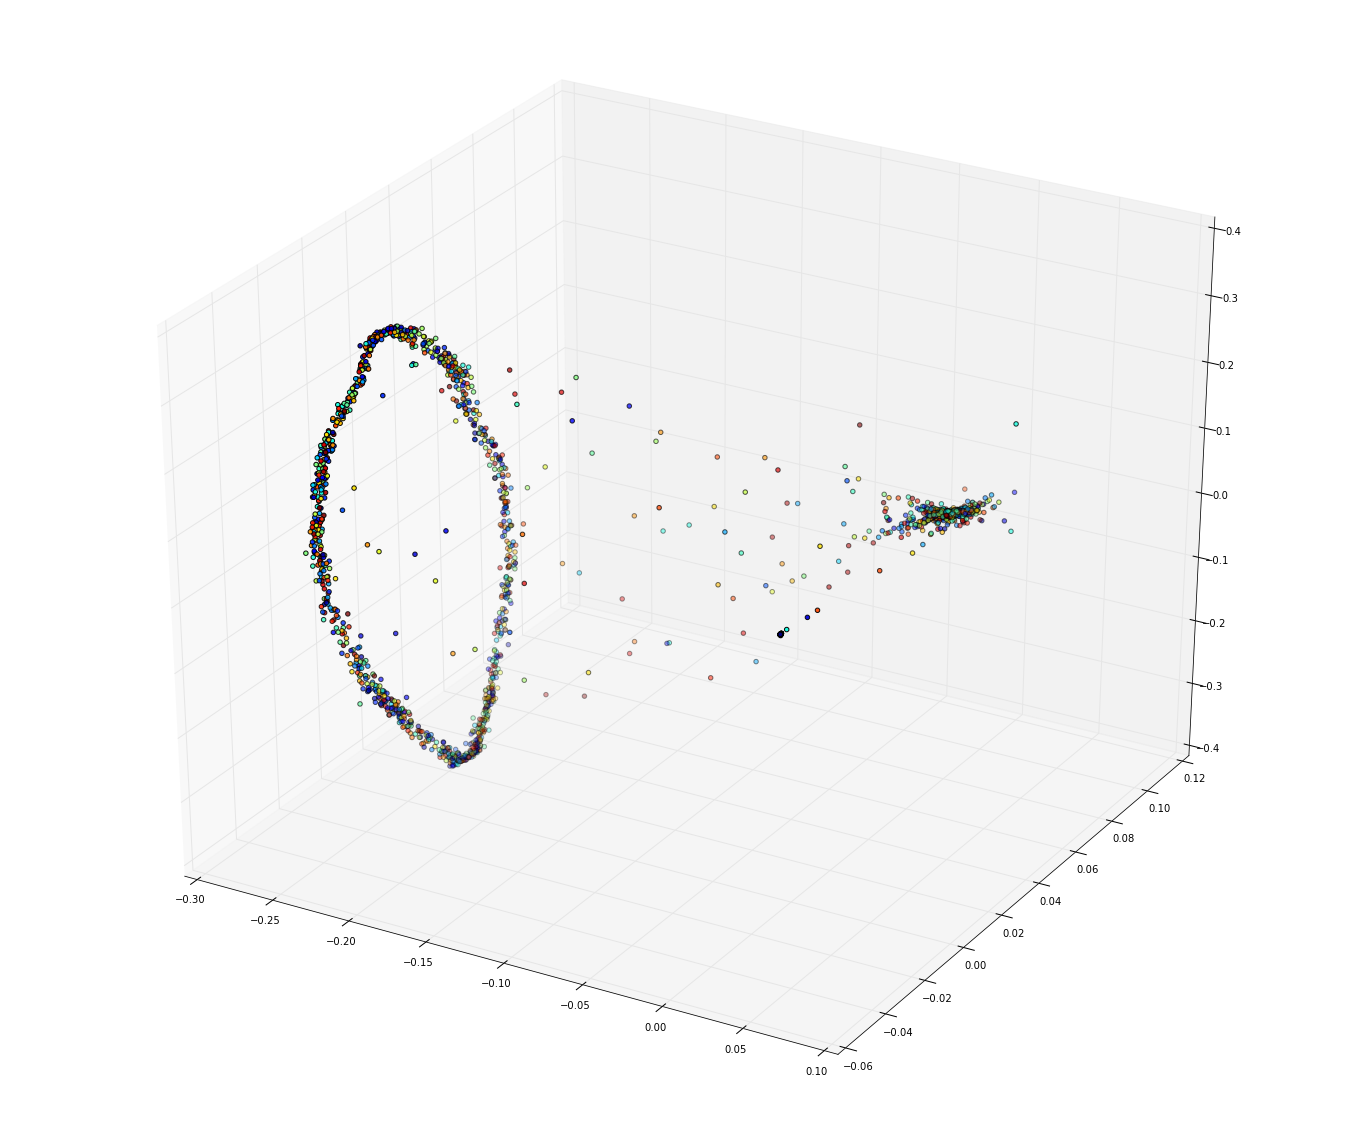

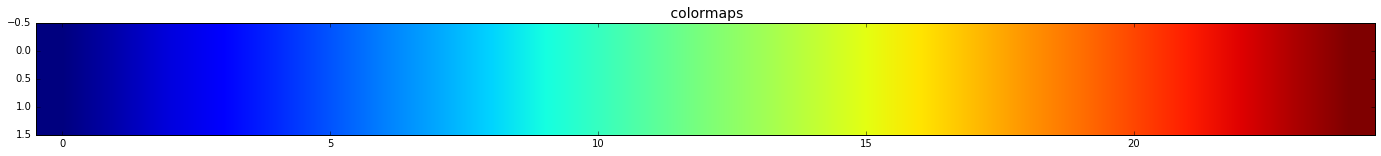

In [57]:
## Using the euclidean (default) metric

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   neighbor_selection = "num_neighbors")

data = e_vecs.T[1:].T
colored_3d_plot(data)

## The shape above resebmles a cone. Let's see how the expectation of the photon number corresopnds to the parts of the cone.

In [142]:
def plot_by_operator(data,traj1,operator = "photon_num"):
    
    if operator == "photon_num":
        num = np.asmatrix(np.diag([i for i in range(params['Nfock'])]*2))
        num_expects = np.asarray([(i*num*i.T)[0,0] for i in np.asmatrix(traj1)])
    else:
        raise ValueError("operator type not implemented")
       
    ## sort data by expected photon number
    num_expects_indices = [(i,n) for i,n in enumerate(num_expects)]
    sorted_num_expects = sorted(num_expects_indices, key = lambda z: z[1])
    data_by_num = [data[i[0]] for i in sorted_num_expects]

    ## Figure 
    fig = plt.figure(figsize=(24,20))
    ax = fig.add_subplot(111, projection='3d')
    to_plot_=[[x[i] for x in data_by_num] for i in xrange(0,3)]

    ## color bar
    x_index = len(np.asarray(to_plot_).T)
    color_list = np.concatenate([np.linspace(0, 1, x_index)] )
    colors = cm.jet(color_list)
    ax.scatter(*np.asarray(to_plot_),c=colors)
    show_colorbar(x_index,'jet')

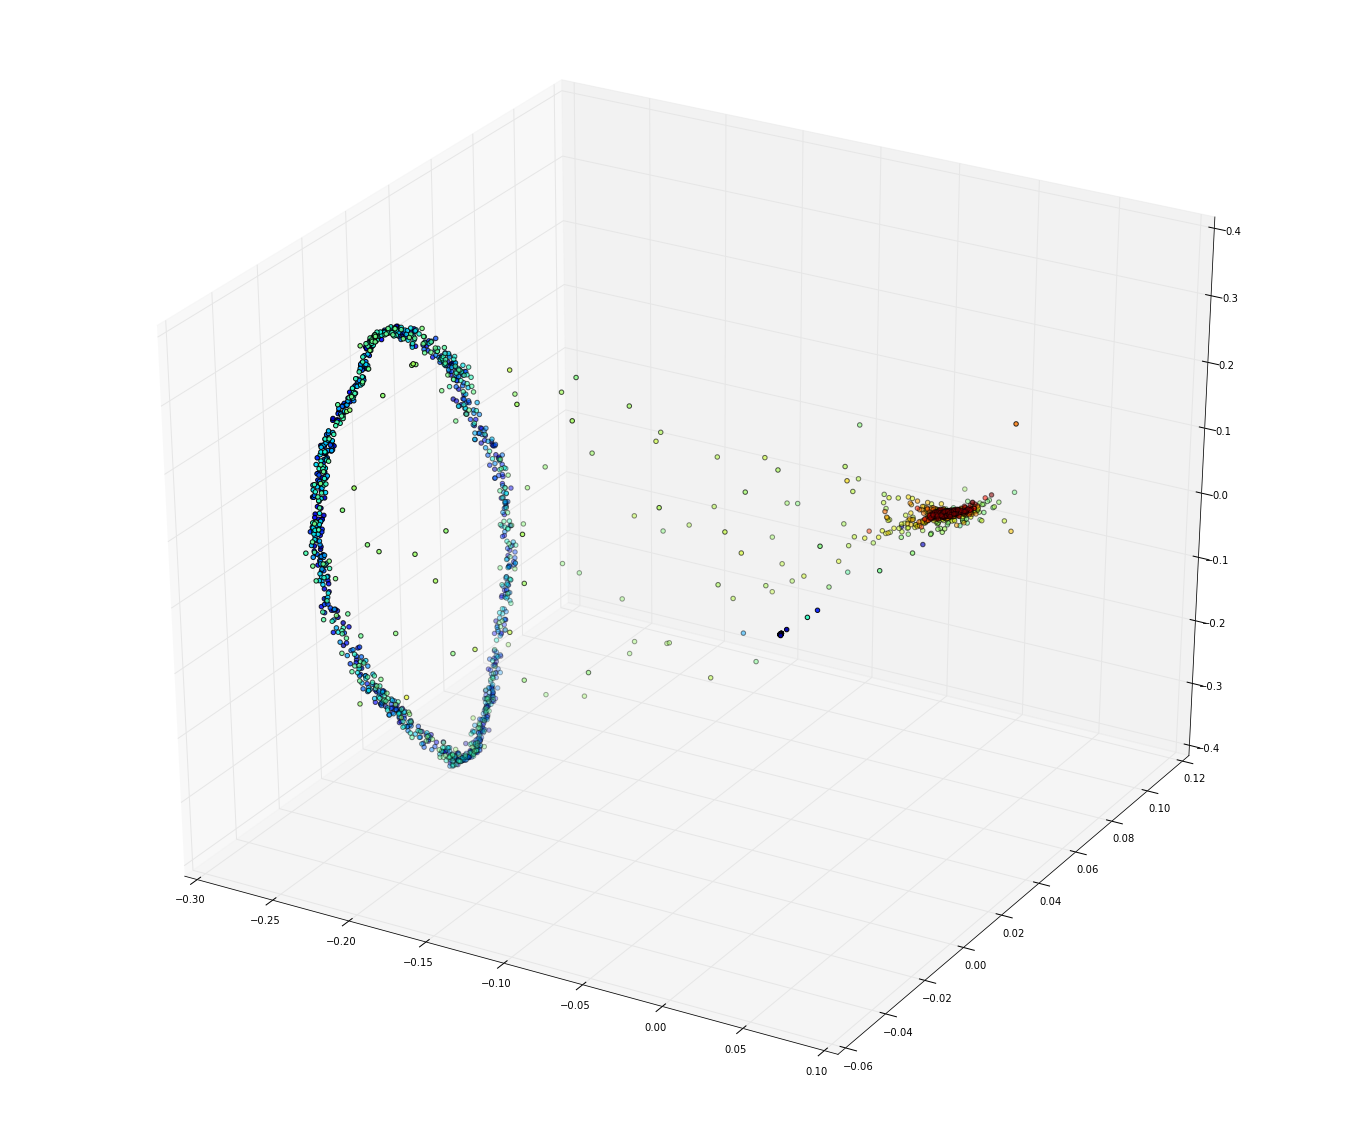

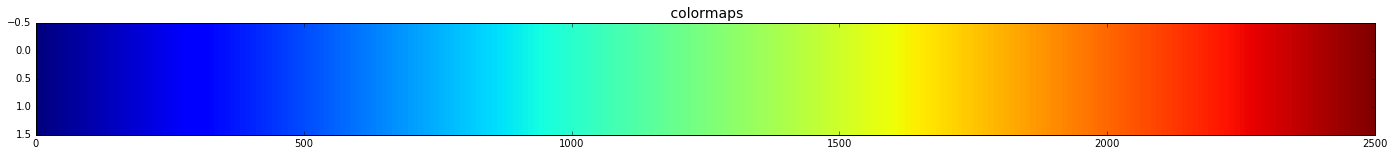

In [145]:
plot_by_operator(data,traj1)

# Fubini-Study metric below!

In [152]:
## Using the euclidean (default) metric
diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                   diffusion_params,
                                   symmetric=True,
                                   metric = "FS_metric",
                                   neighbor_selection = "num_neighbors")

using num_neighbors  


In [153]:
data = e_vecs.T[1:].T

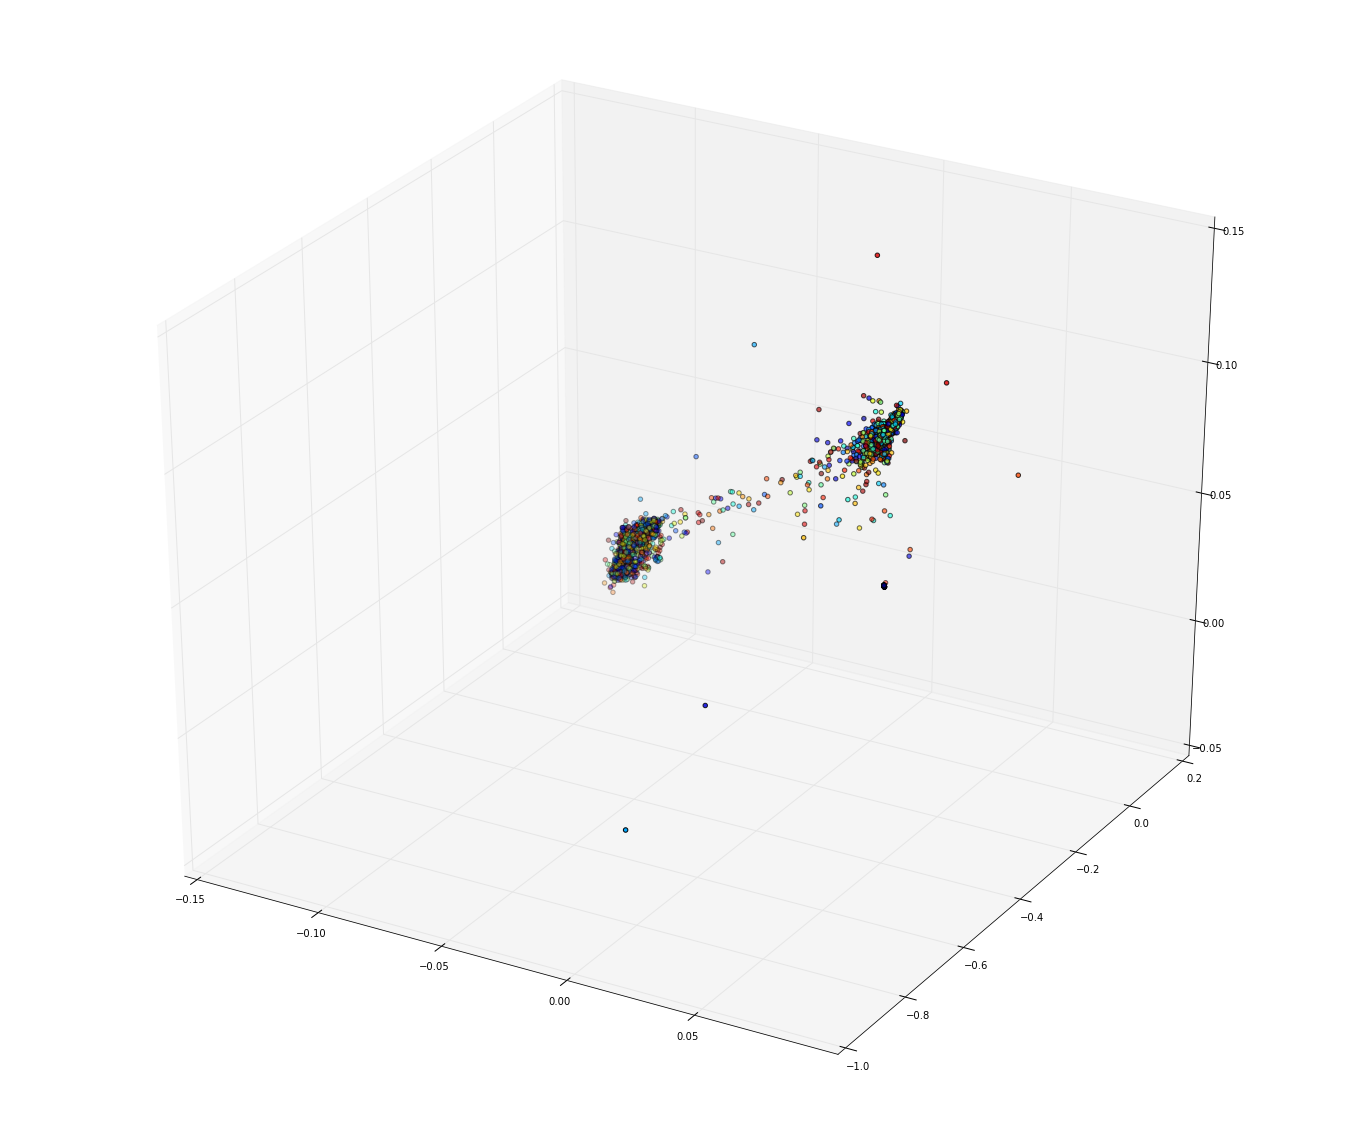

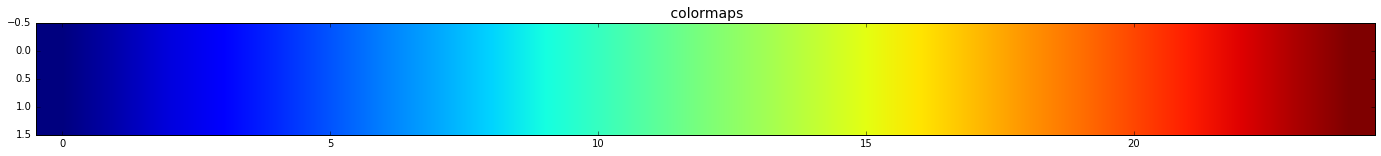

In [154]:
colored_3d_plot(data)

## Again, let's color by photon number expectation:

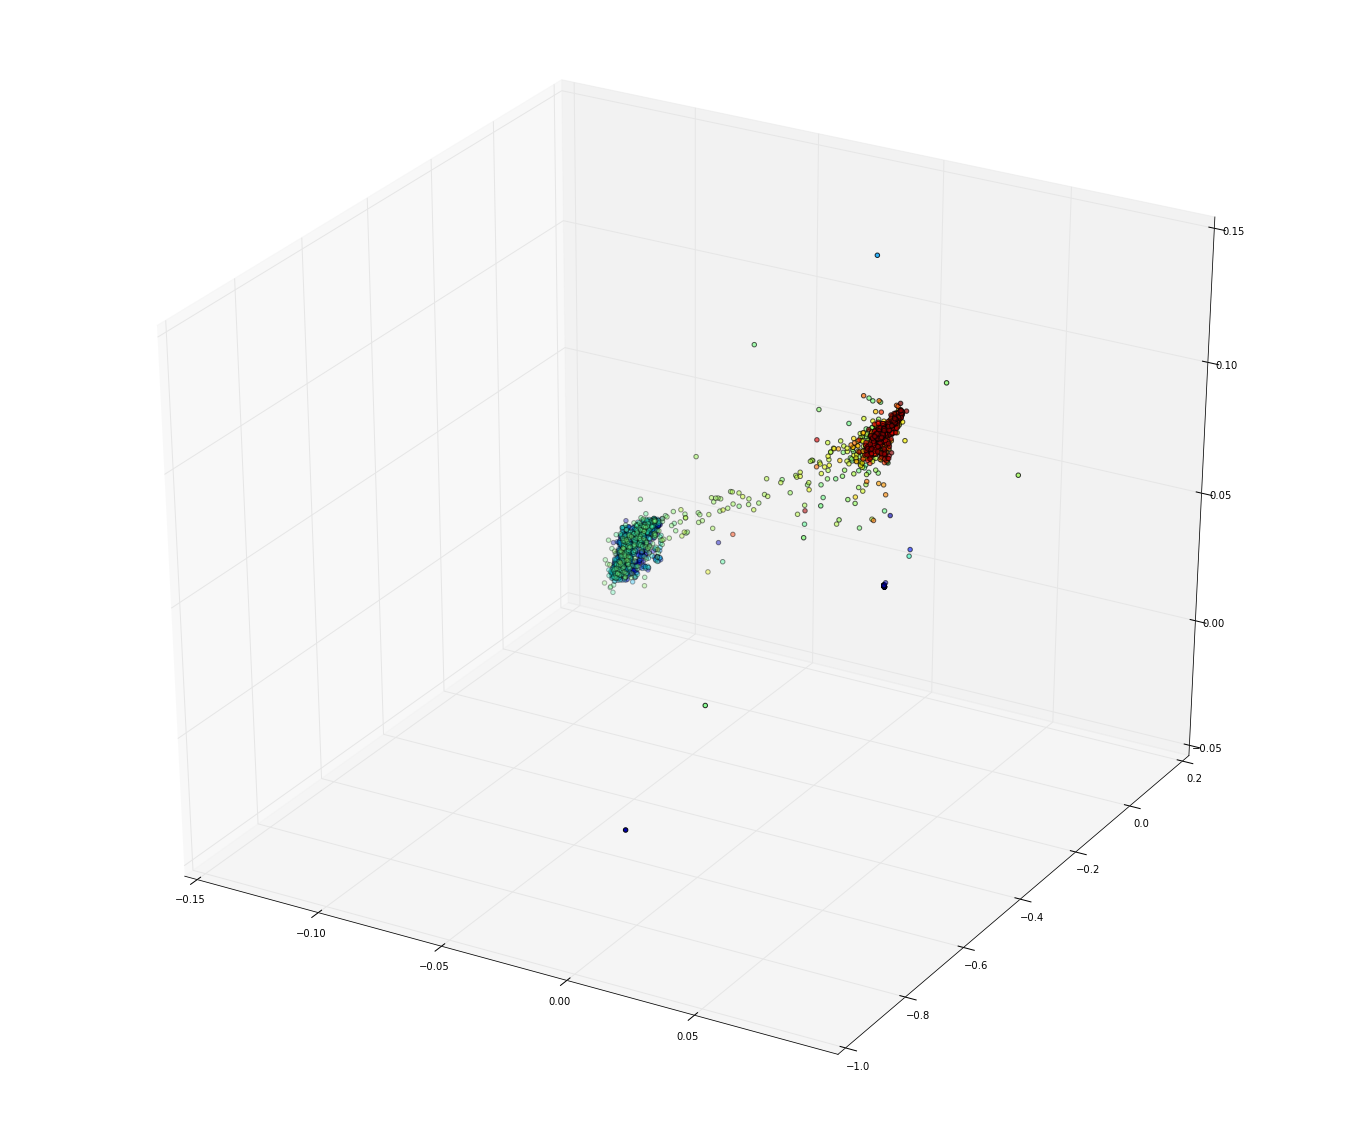

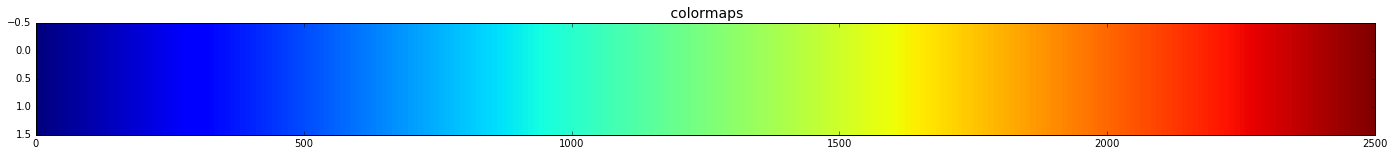

In [155]:
plot_by_operator(data,traj1)

## Diffusion maps down to a two-dimensional space (`eigen_dims` == 3)

In [10]:
def diffusion_map_2D_plot():
    diffusion_params["eigen_dims"] = 3 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

    e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                       diffusion_params,
                                       symmetric=True,
                                       metric = "FS_metric",
                                       neighbor_selection = "num_neighbors")

    plt.scatter(*e_vecs[:,1:].T)

using num_neighbors  


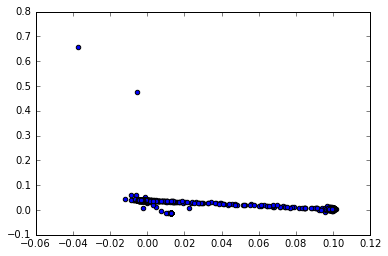

In [11]:
diffusion_params["gaussian_epsilon"] = 0.1
diffusion_map_2D_plot()

## Let's change the `gaussian_epsilon` parameter

using num_neighbors  


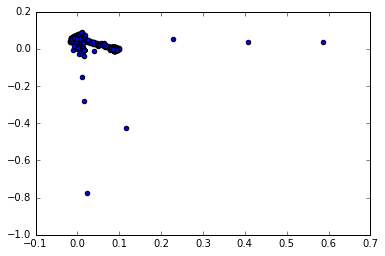

In [12]:
diffusion_params["gaussian_epsilon"] = 0.2
diffusion_map_2D_plot()

# What happens if we apply the algorithm at different times (to all trajectories). We split time to chunks of `slice_len`. 

In [159]:
Ntraj = params['Ntraj']
duration = params['duration']

slice_len = 500
trajs = np.split(data_traj,Ntraj)
traj_overtime = [np.concatenate([t[slice_len*i : slice_len*(i+1)] for t in trajs])[0::20] for i in range(int(duration/slice_len))]

In [163]:
def run_diffusion_maps_time_slices_plot_3d(metric = "FS_metric", sorting = "time"):
    diffusion_params["eigen_dims"] = 4 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

    for t,traj1 in enumerate(traj_overtime):
        e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                           diffusion_params,
                                           symmetric=True,
                                           metric = metric,
                                           neighbor_selection = "num_neighbors")
        data = e_vecs.T[1:].T

        if sorting == "time":
            data_plot = data
        if sorting == "photon_num":
            
            num = np.asmatrix(np.diag([i for i in range(params['Nfock'])]*2))
            num_expects = np.asarray([(i*num*i.T)[0,0] for i in np.asmatrix(traj1)])

            ## sort data by expected photon number
            num_expects_indices = [(i,n) for i,n in enumerate(num_expects)]
            sorted_num_expects = sorted(num_expects_indices, key = lambda z: z[1])
            data_plot = [data[i[0]] for i in sorted_num_expects]

        ## figure
        colored_3d_plot(data_plot)
        plt.show()

using num_neighbors  


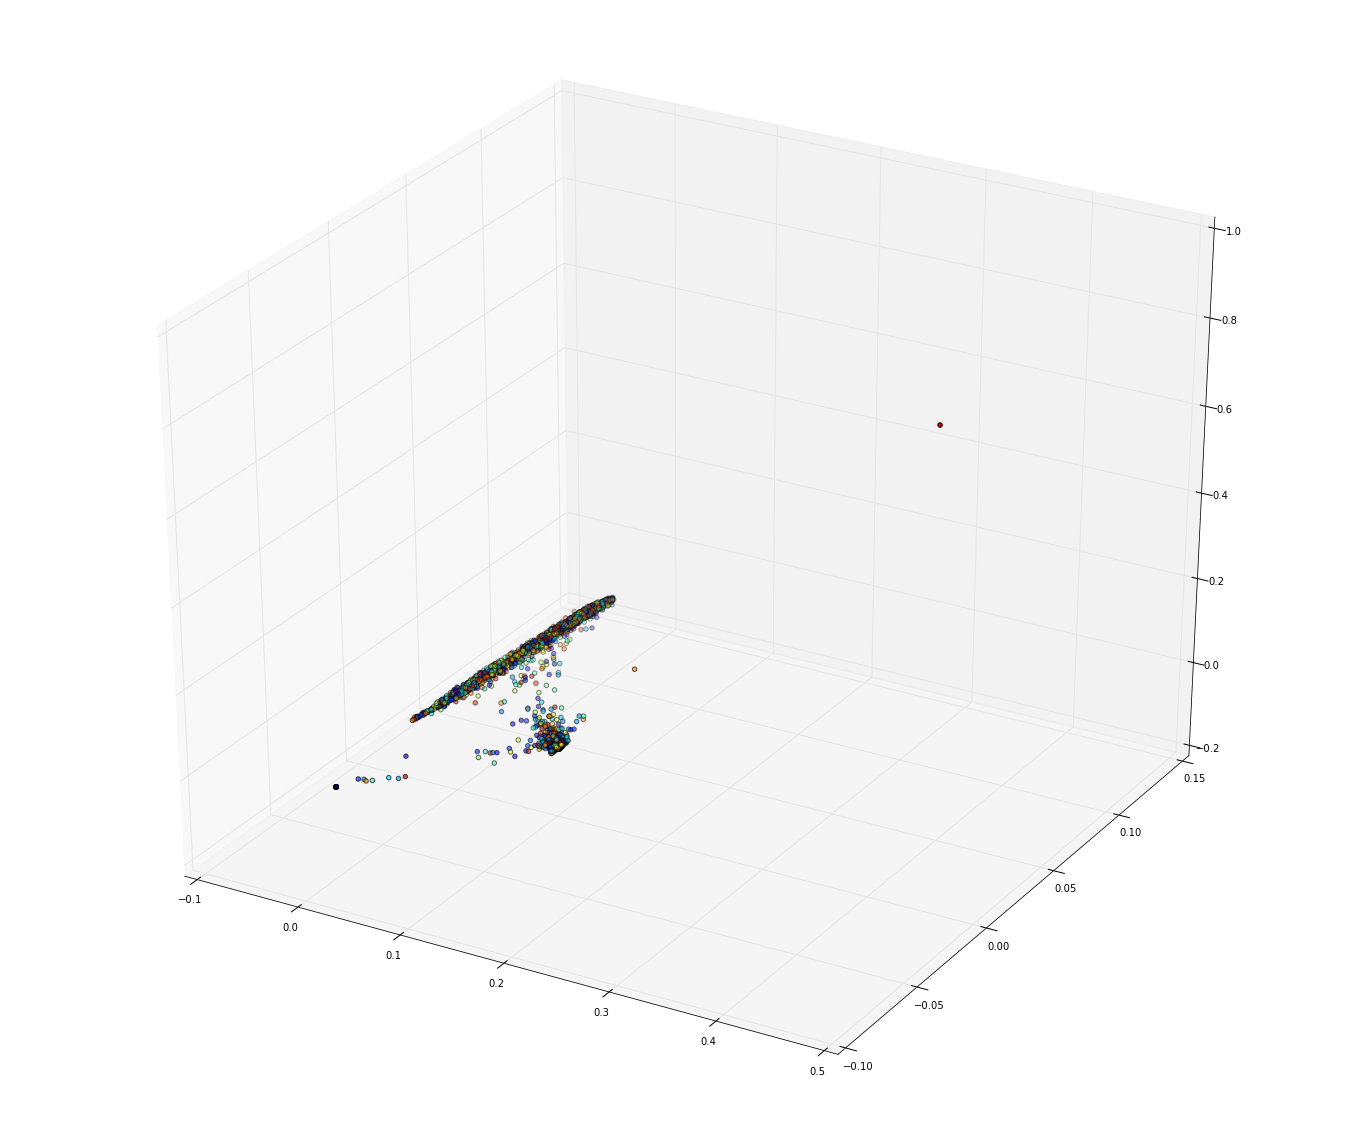

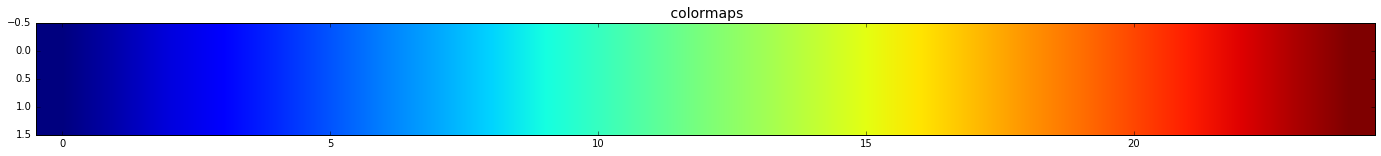

using num_neighbors  


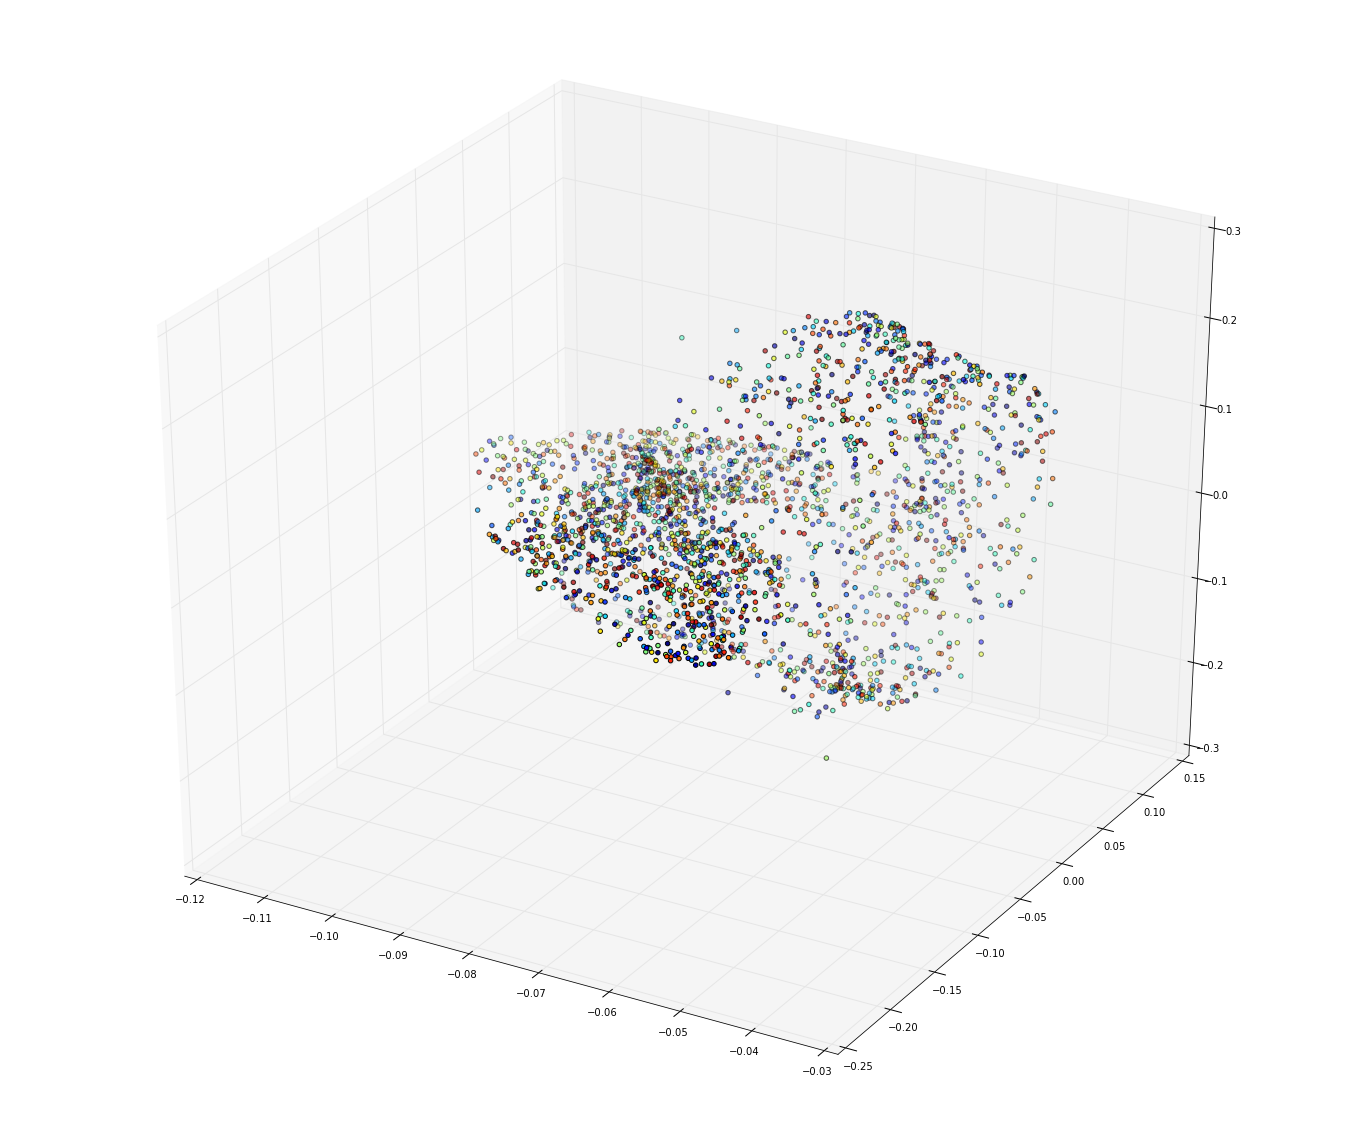

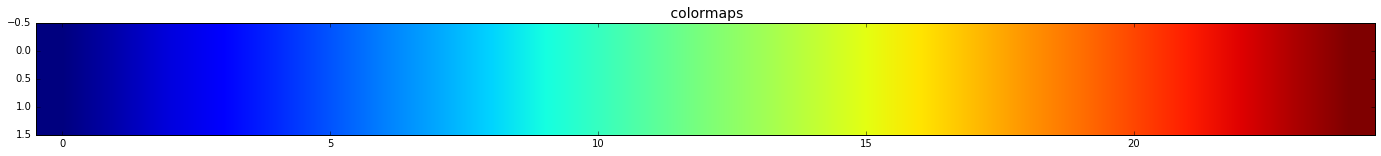

using num_neighbors  


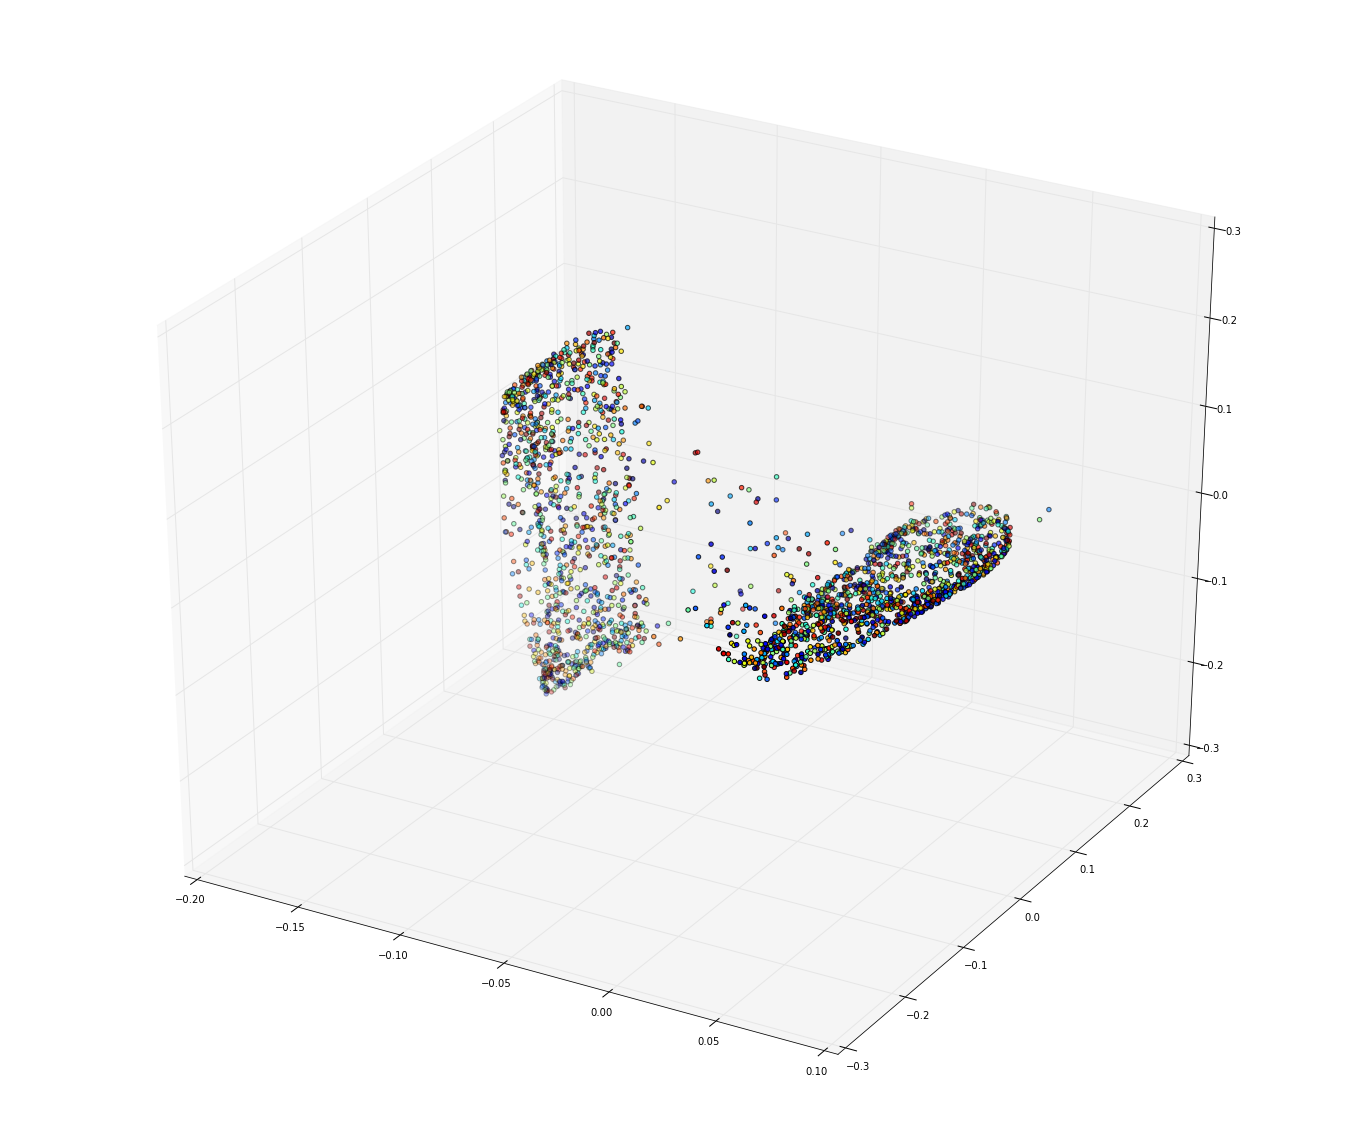

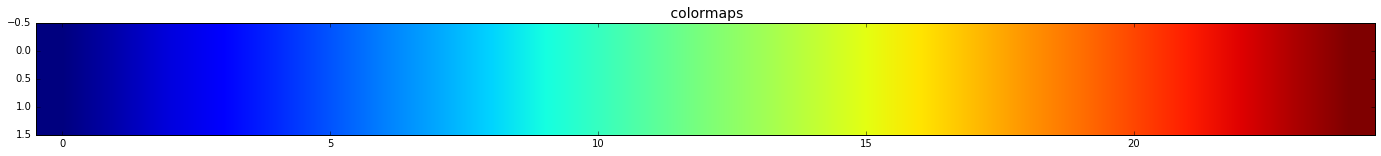

using num_neighbors  


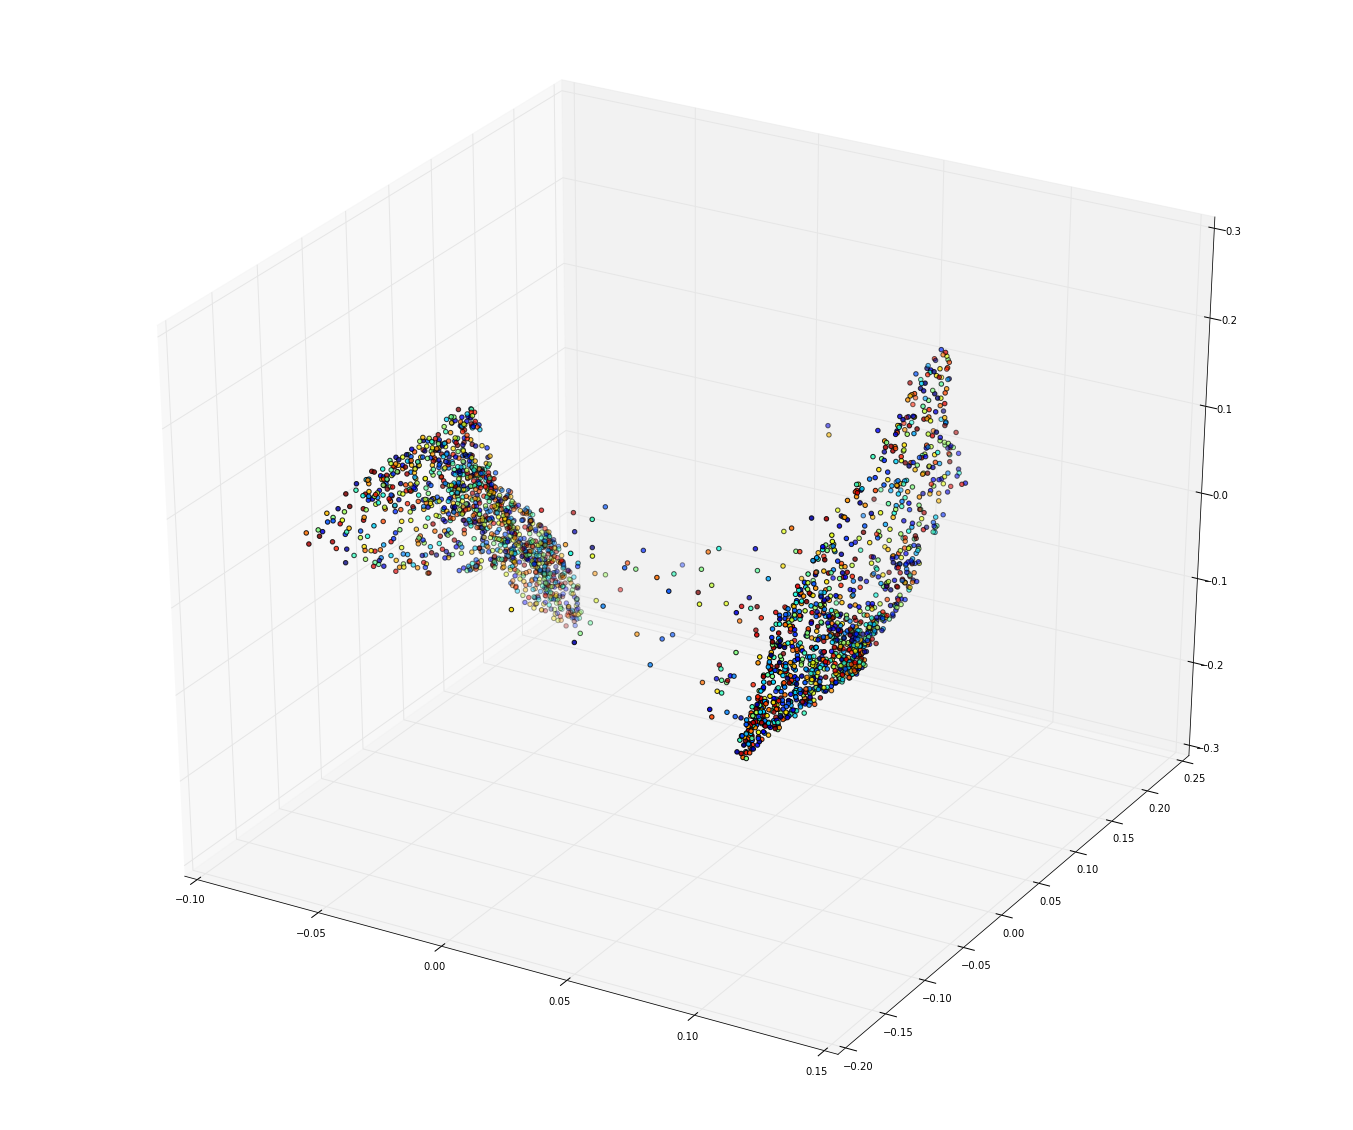

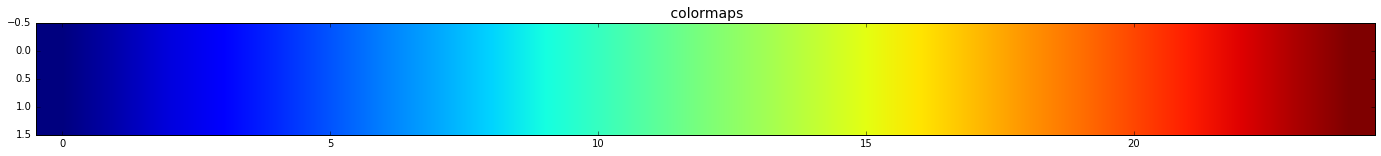

using num_neighbors  


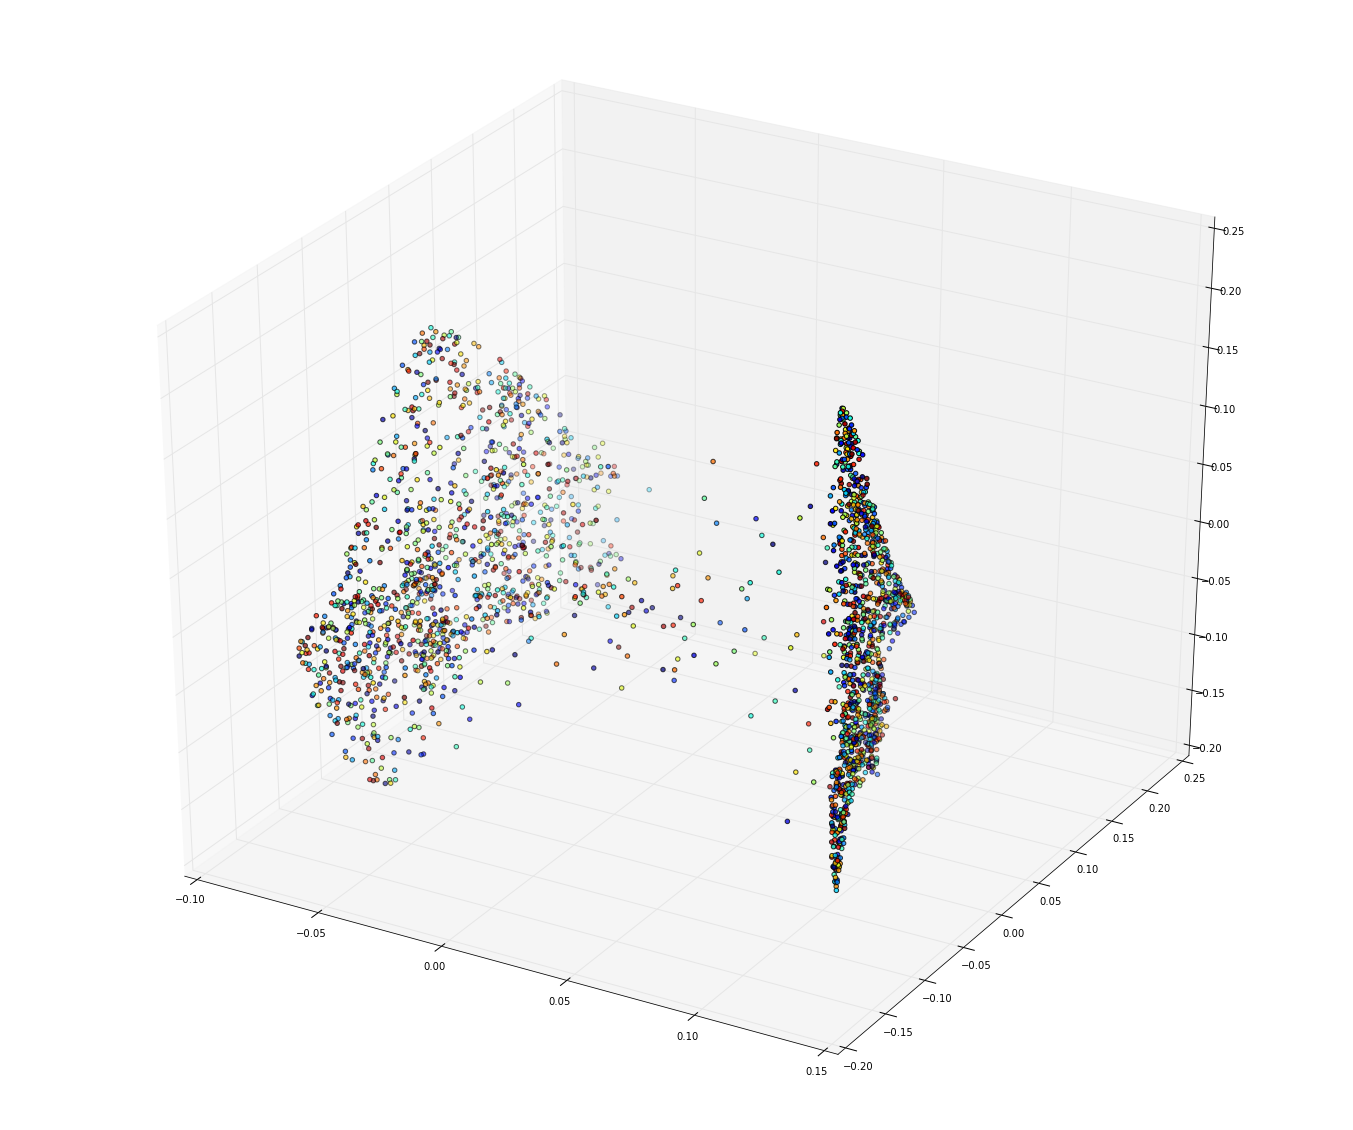

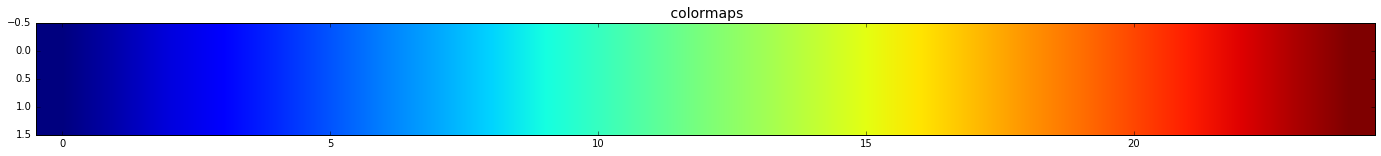

In [49]:
run_diffusion_maps_time_slices_plot_3d()

## Same analysis as above, with different `gaussian_epsilon`.

using num_neighbors  


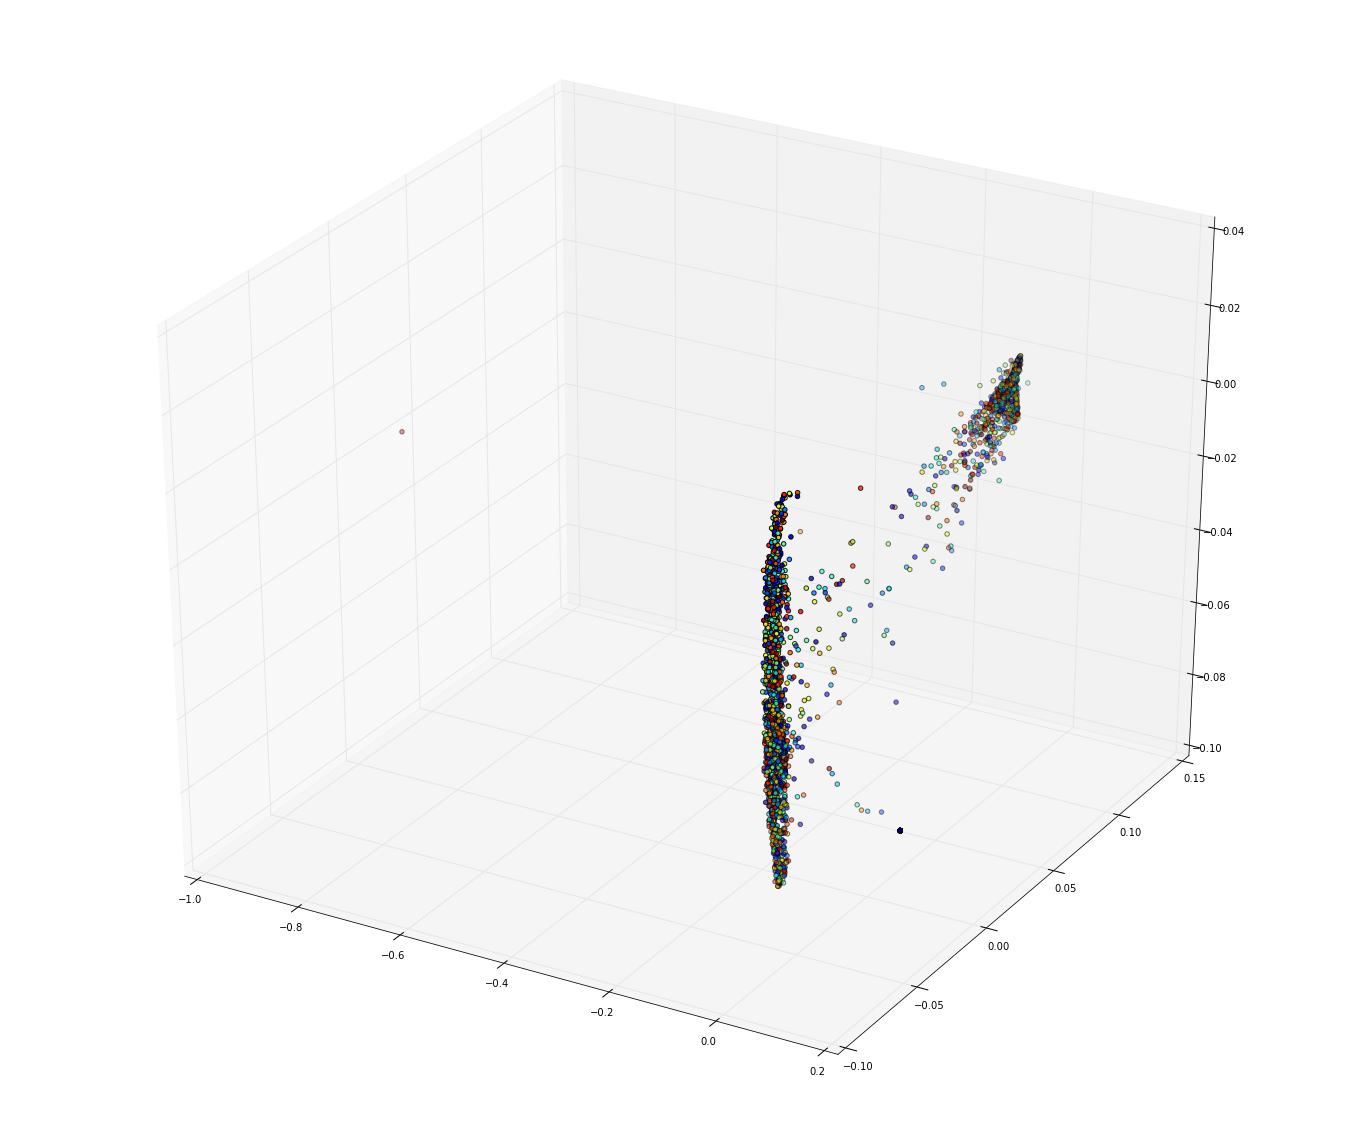

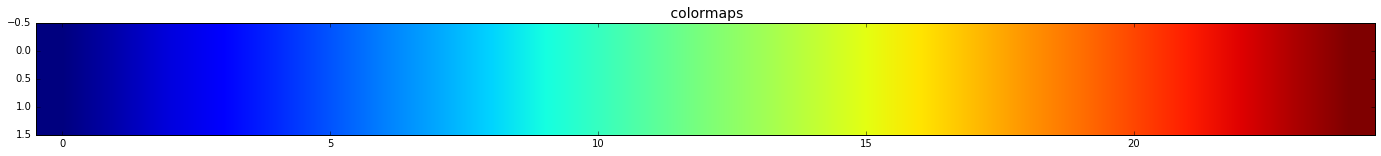

using num_neighbors  


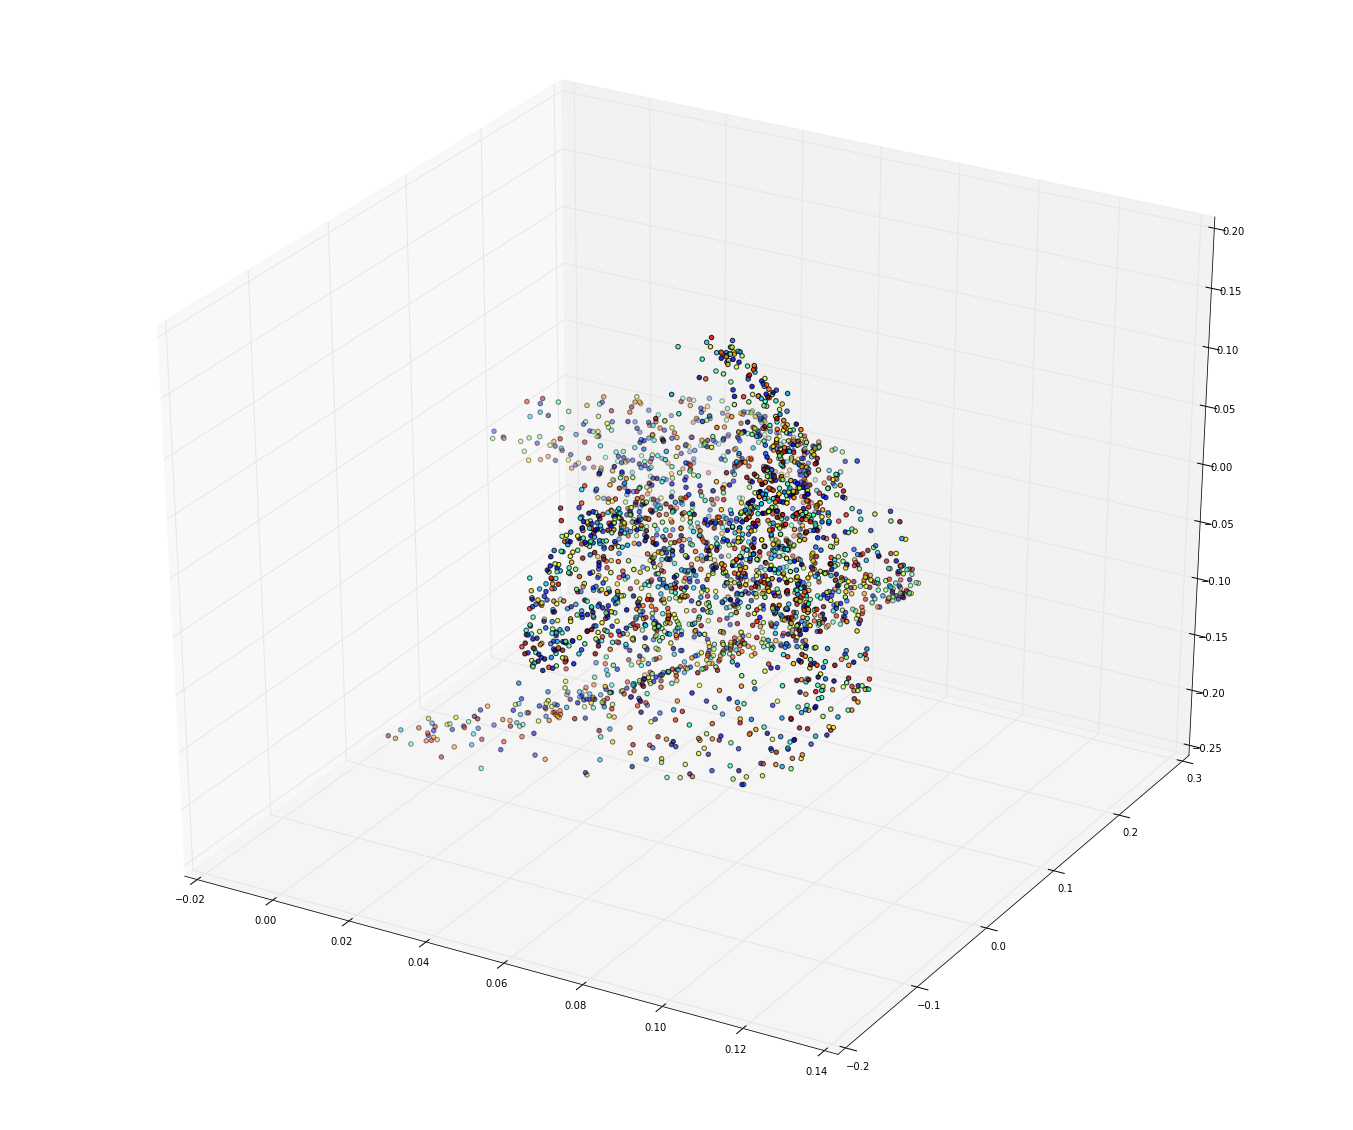

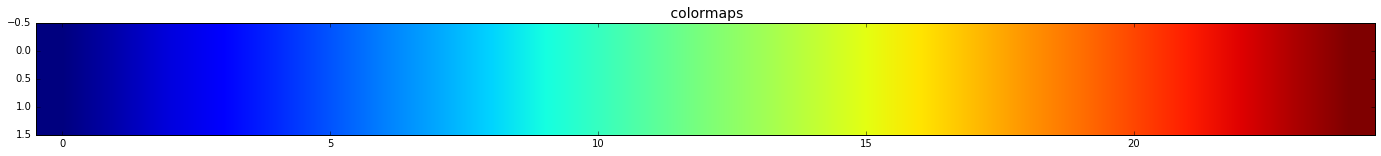

using num_neighbors  


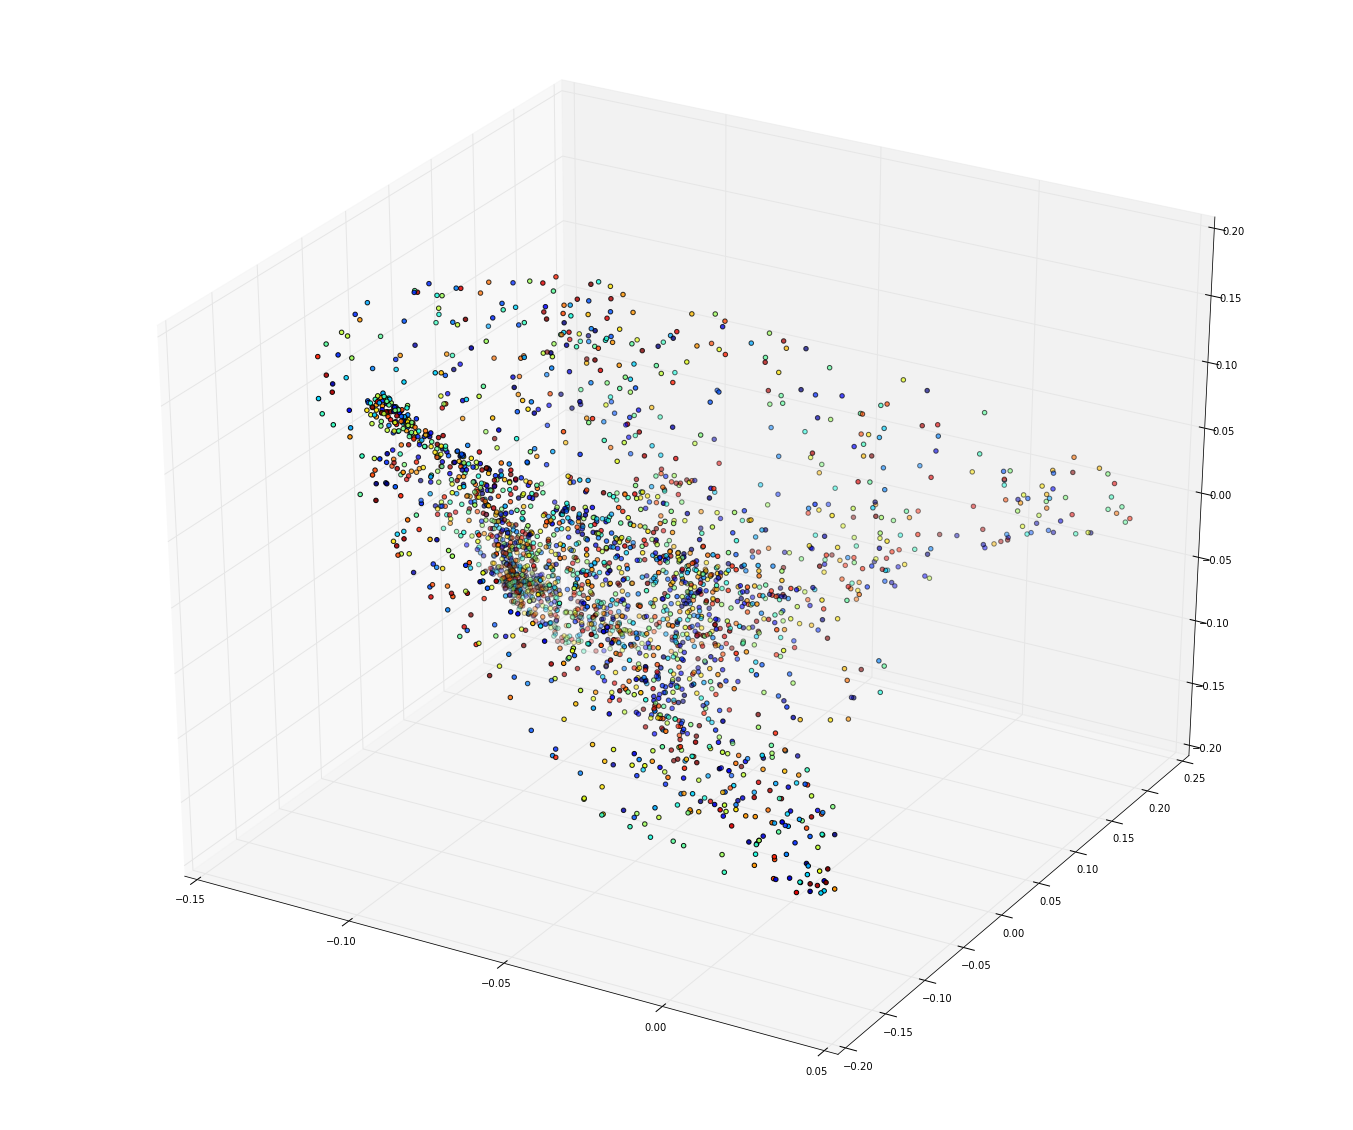

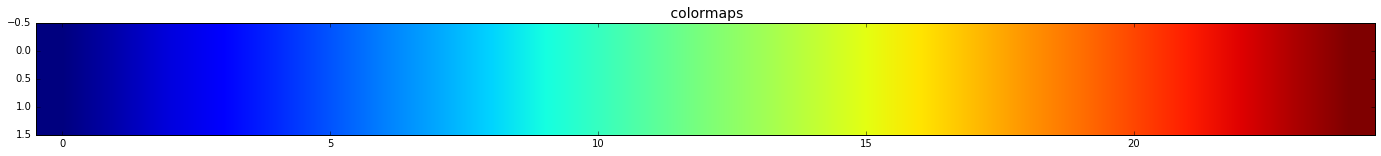

using num_neighbors  


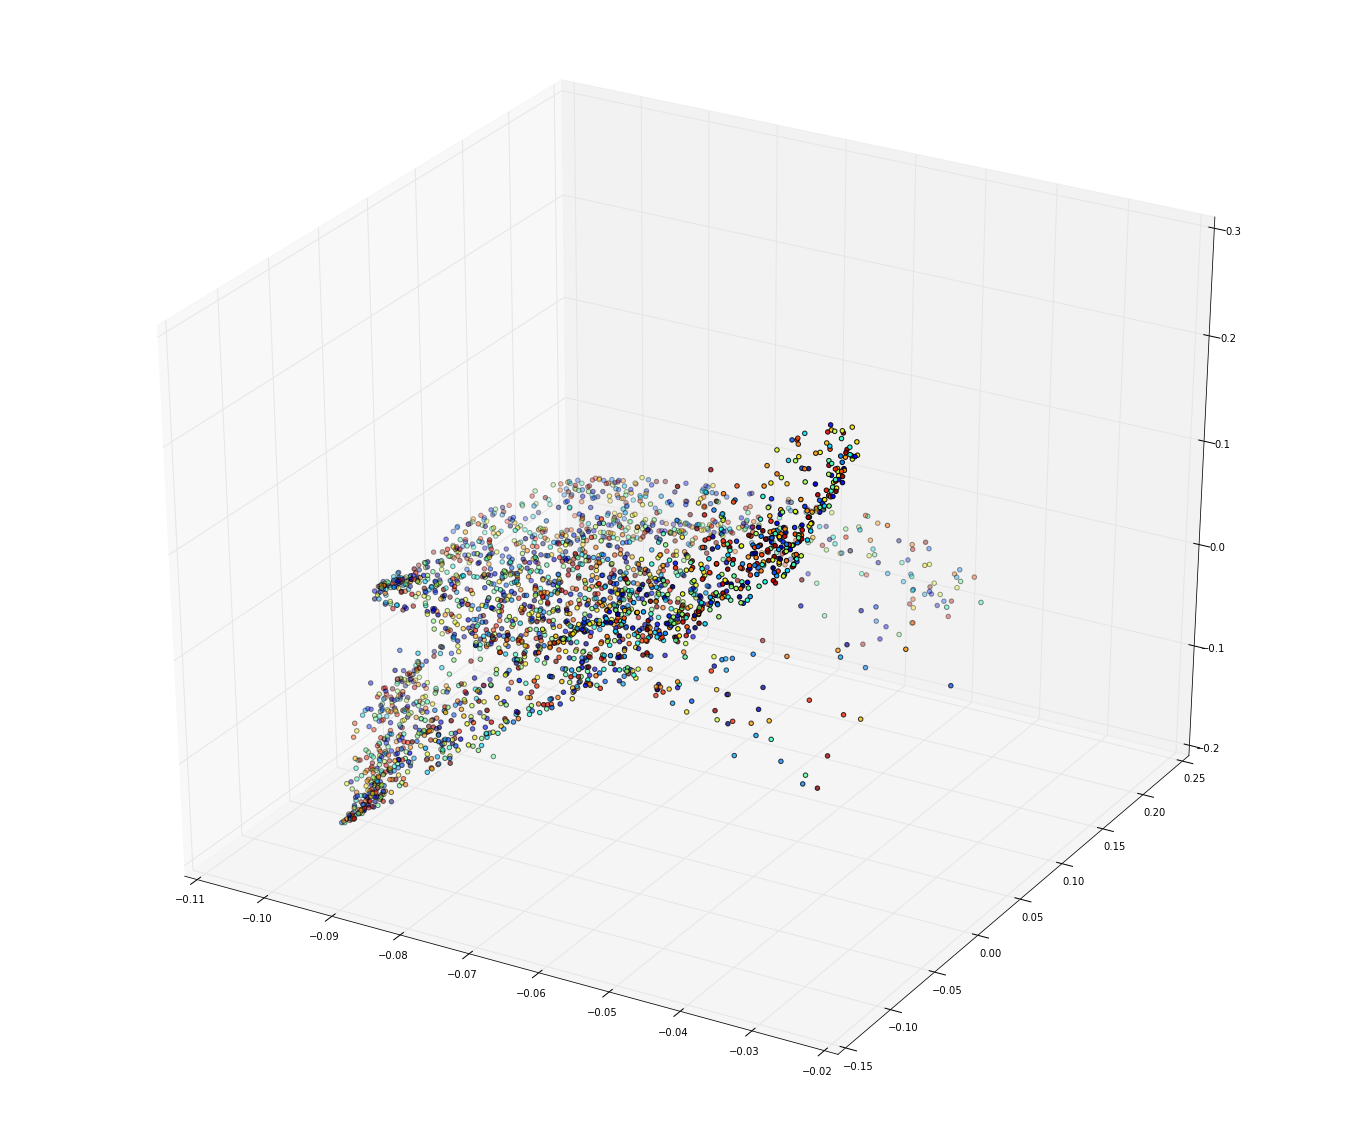

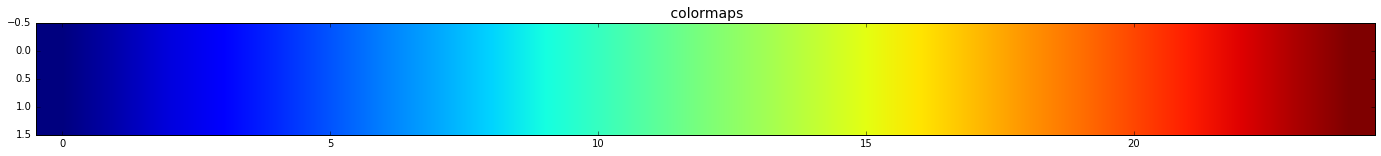

using num_neighbors  


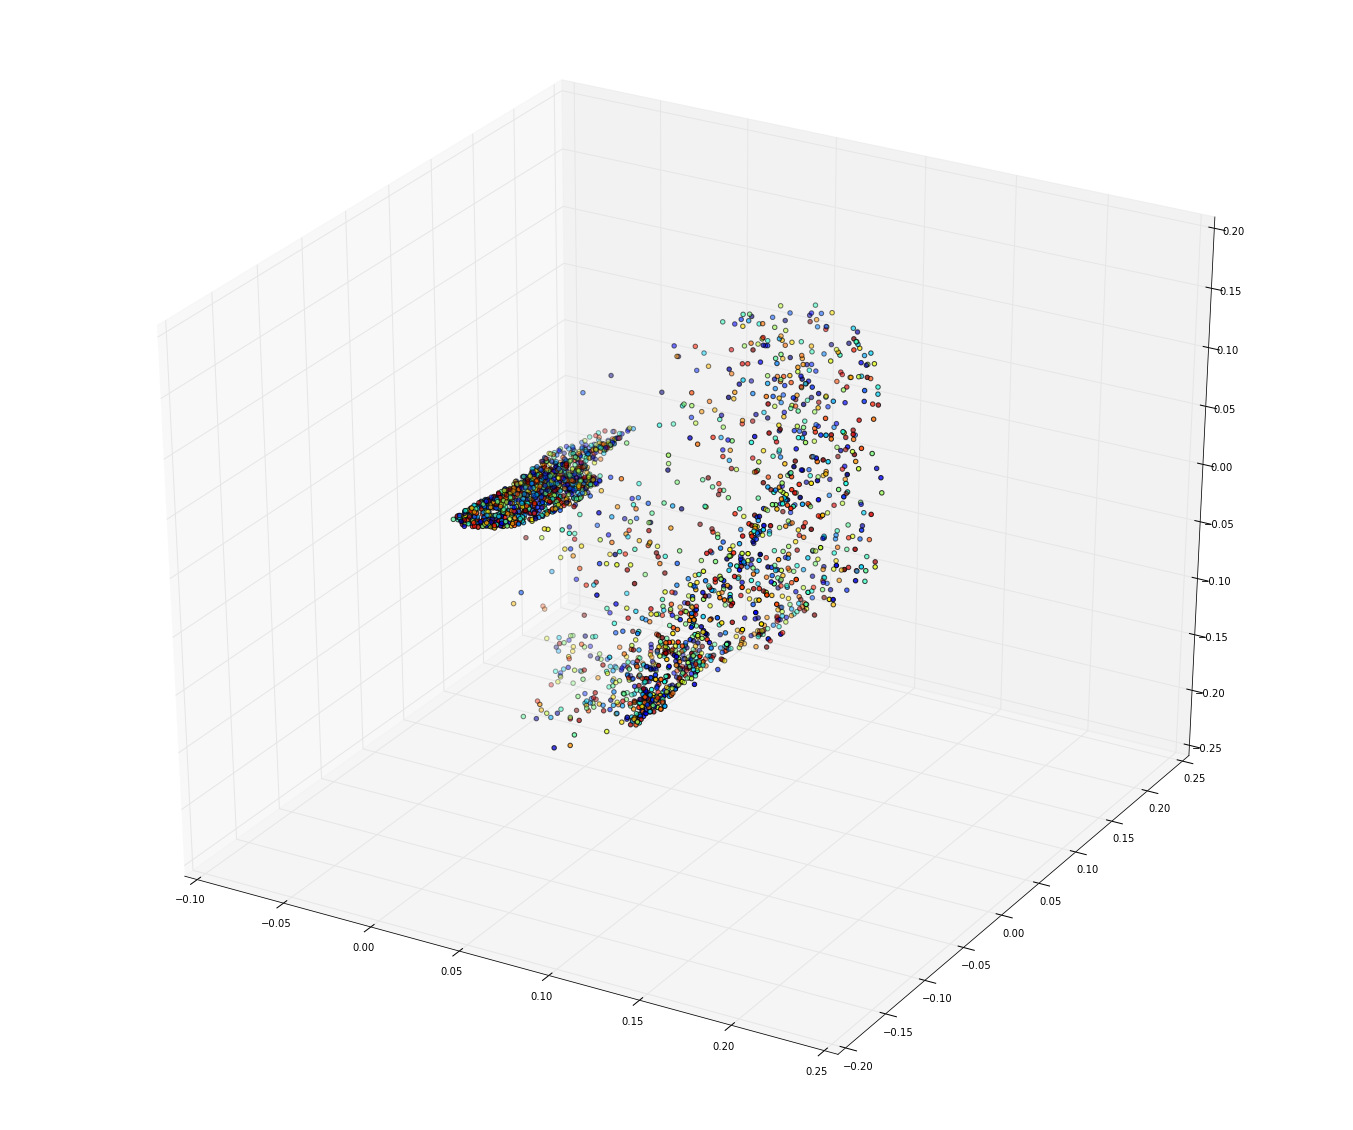

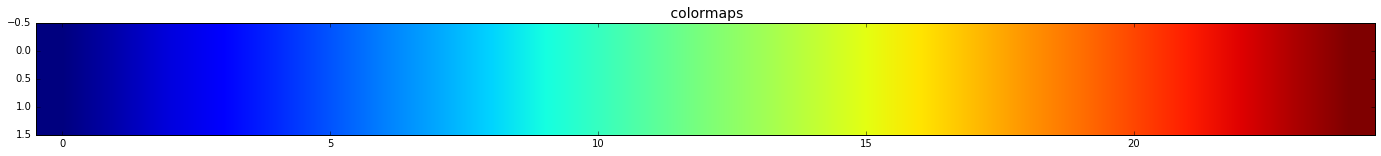

In [50]:
diffusion_params["gaussian_epsilon"] = 0.2 ## width of Gaussian kernel.
run_diffusion_maps_time_slices_plot_3d()

## Below, run a similar analysis but plot instead by expected photon number.

using num_neighbors  


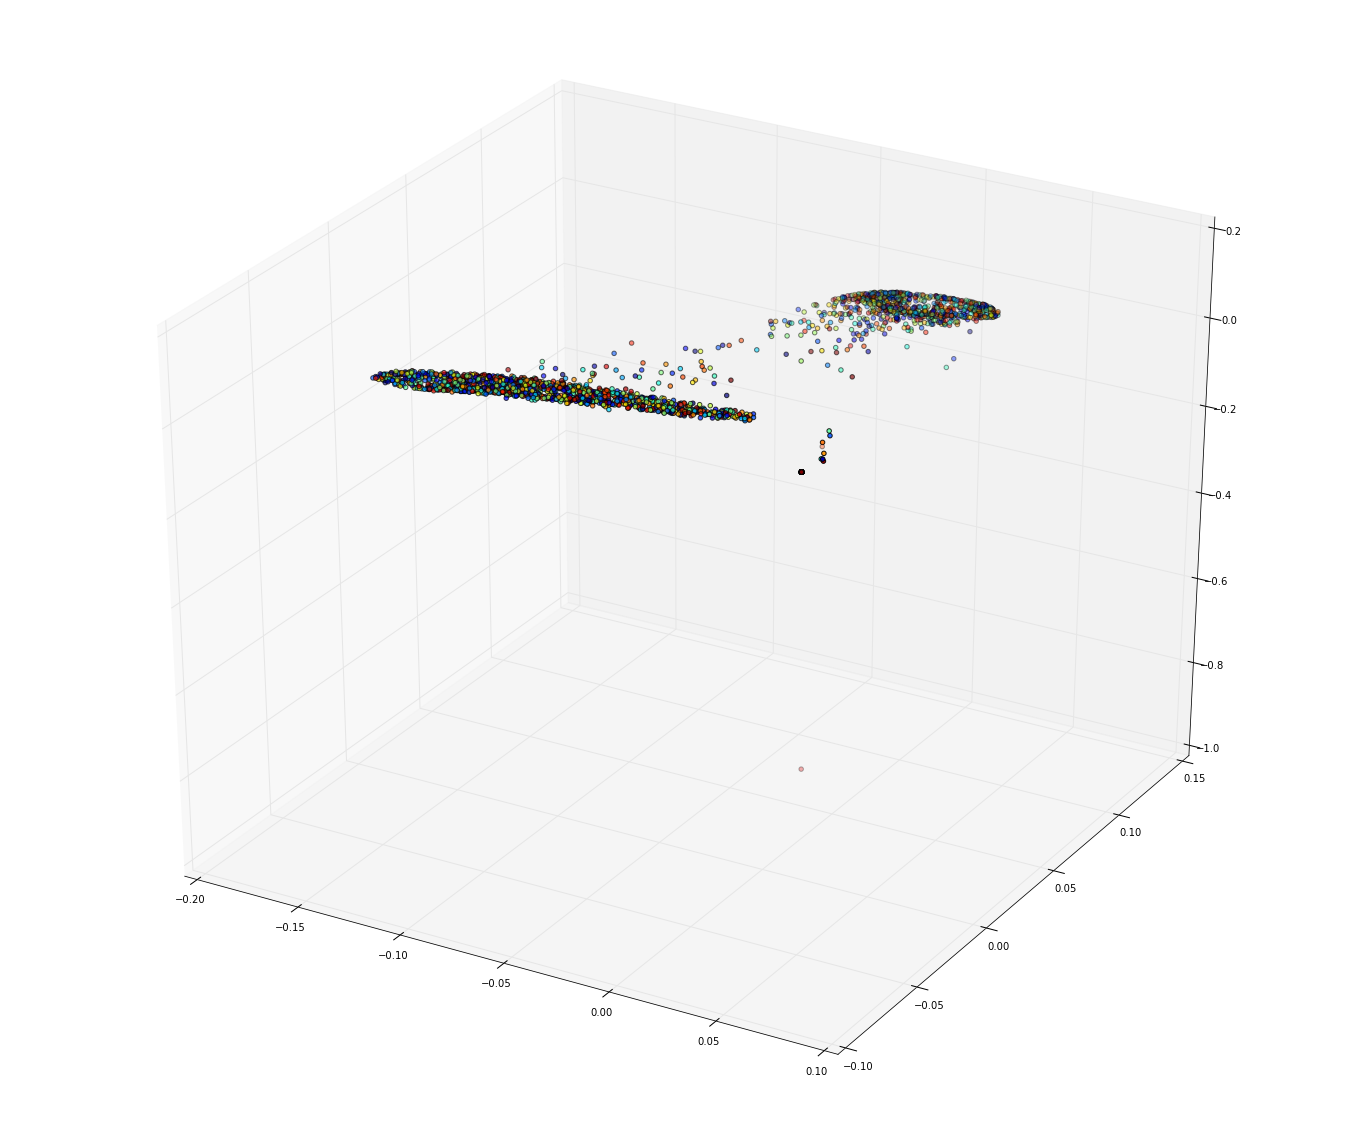

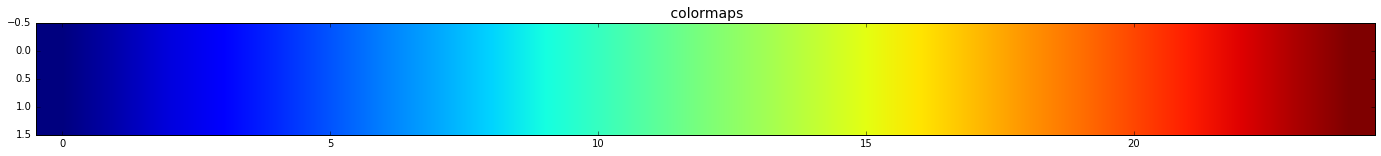

using num_neighbors  


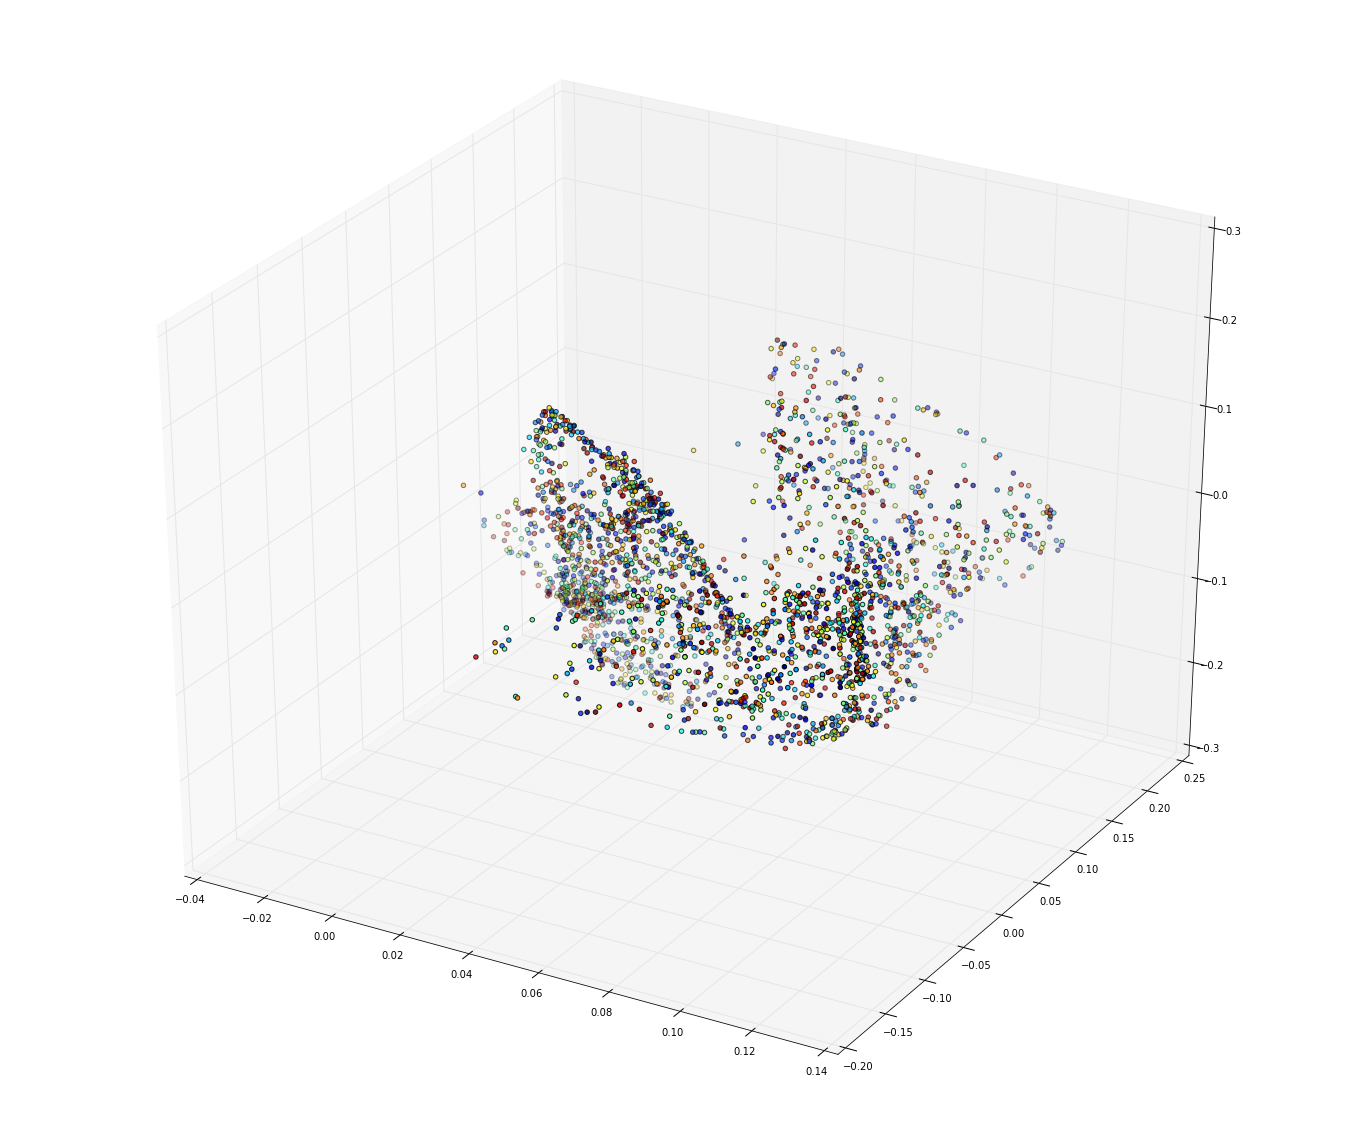

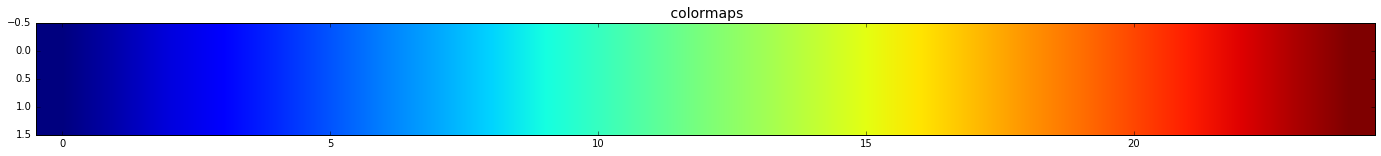

using num_neighbors  


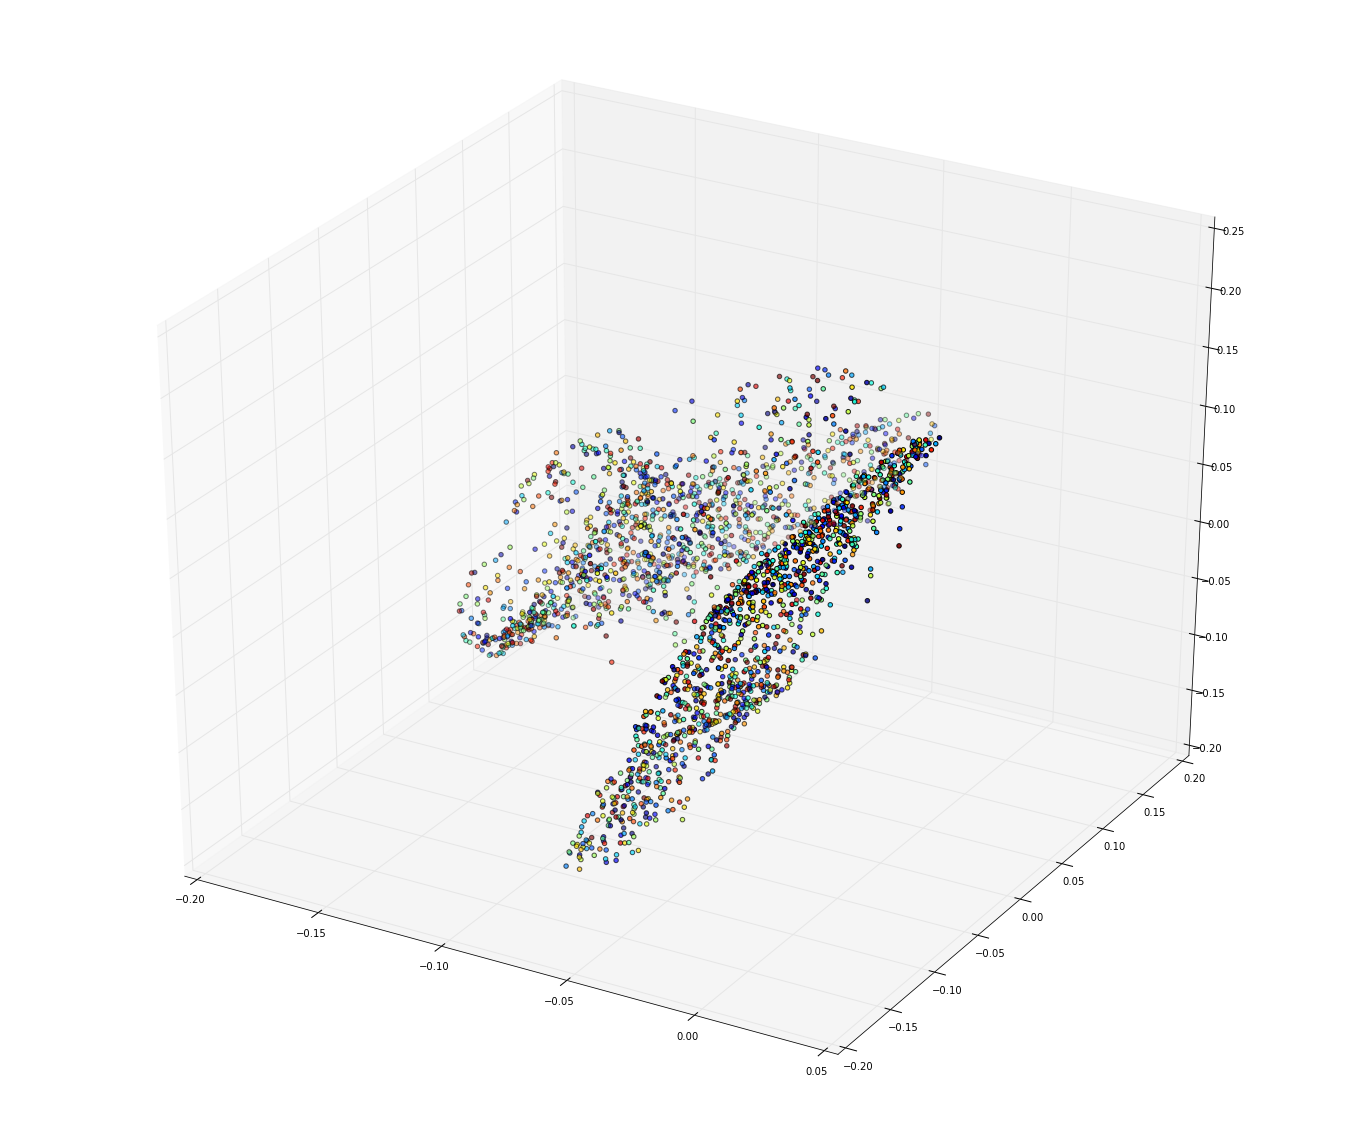

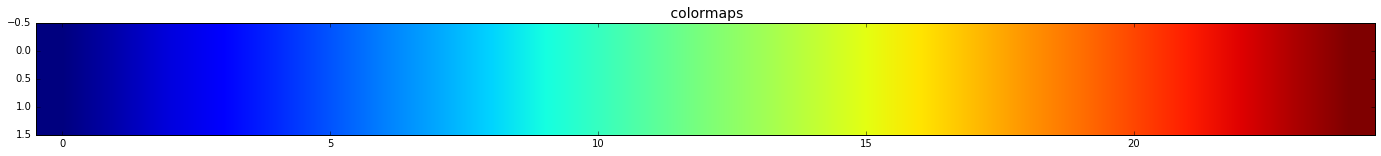

using num_neighbors  


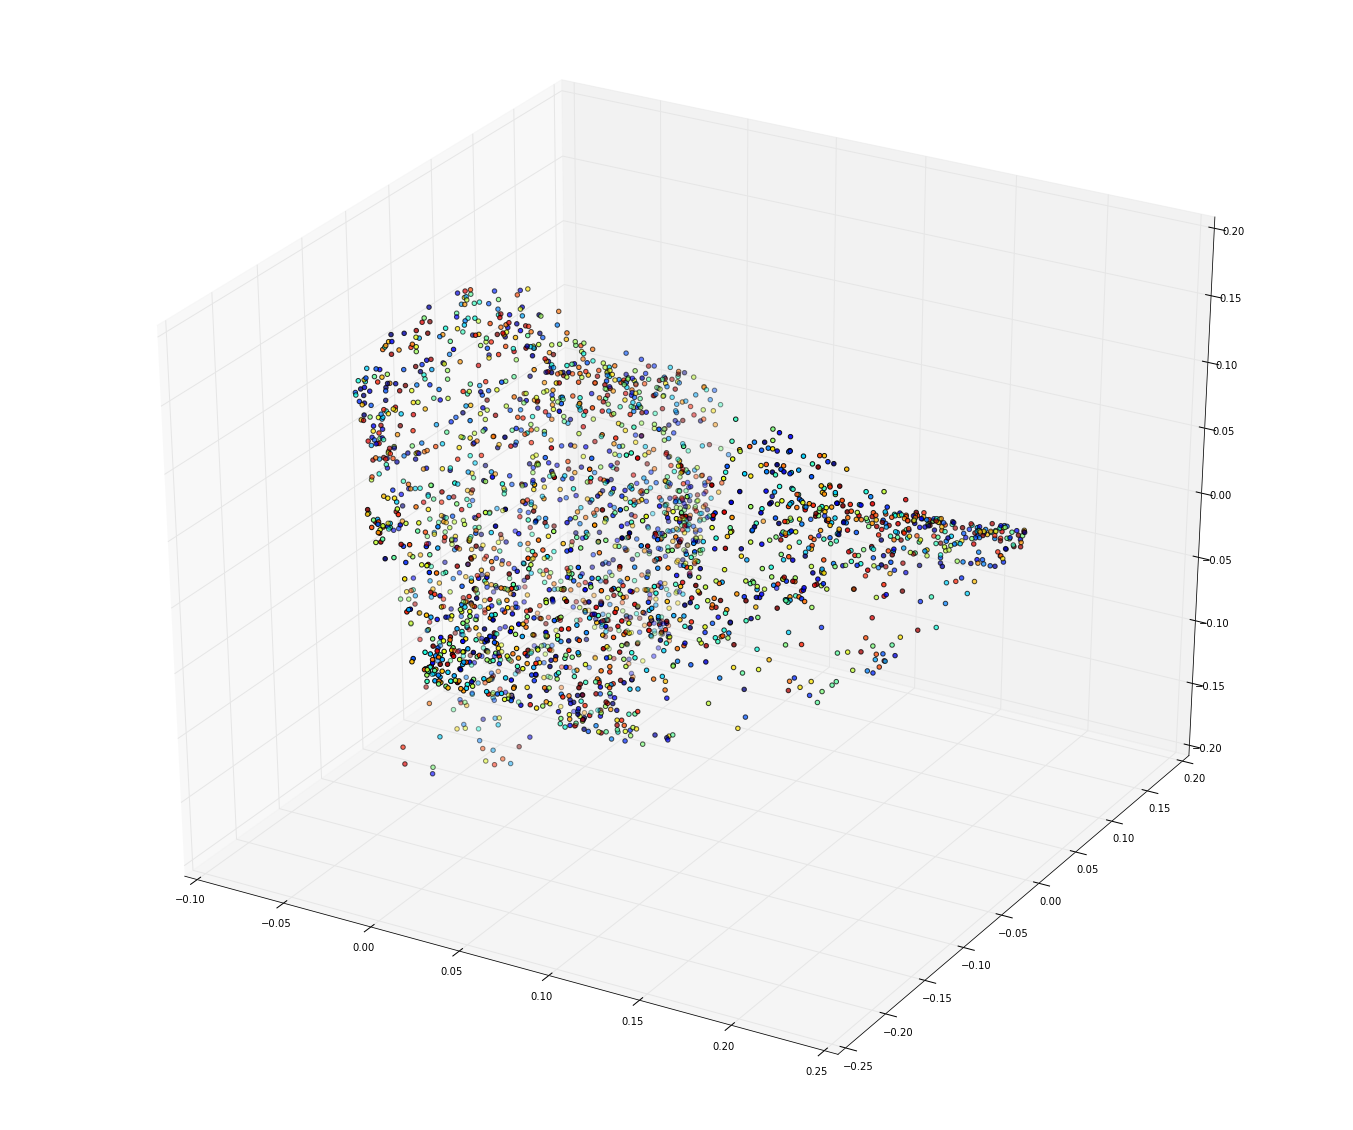

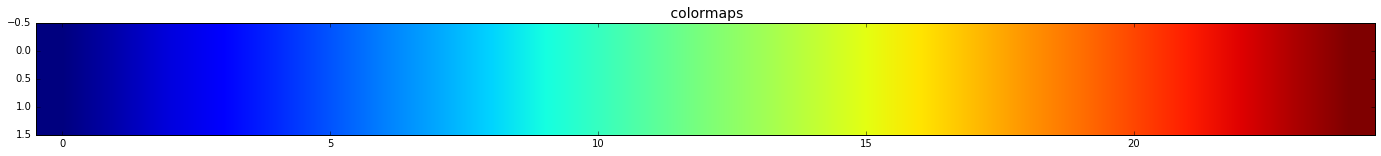

using num_neighbors  


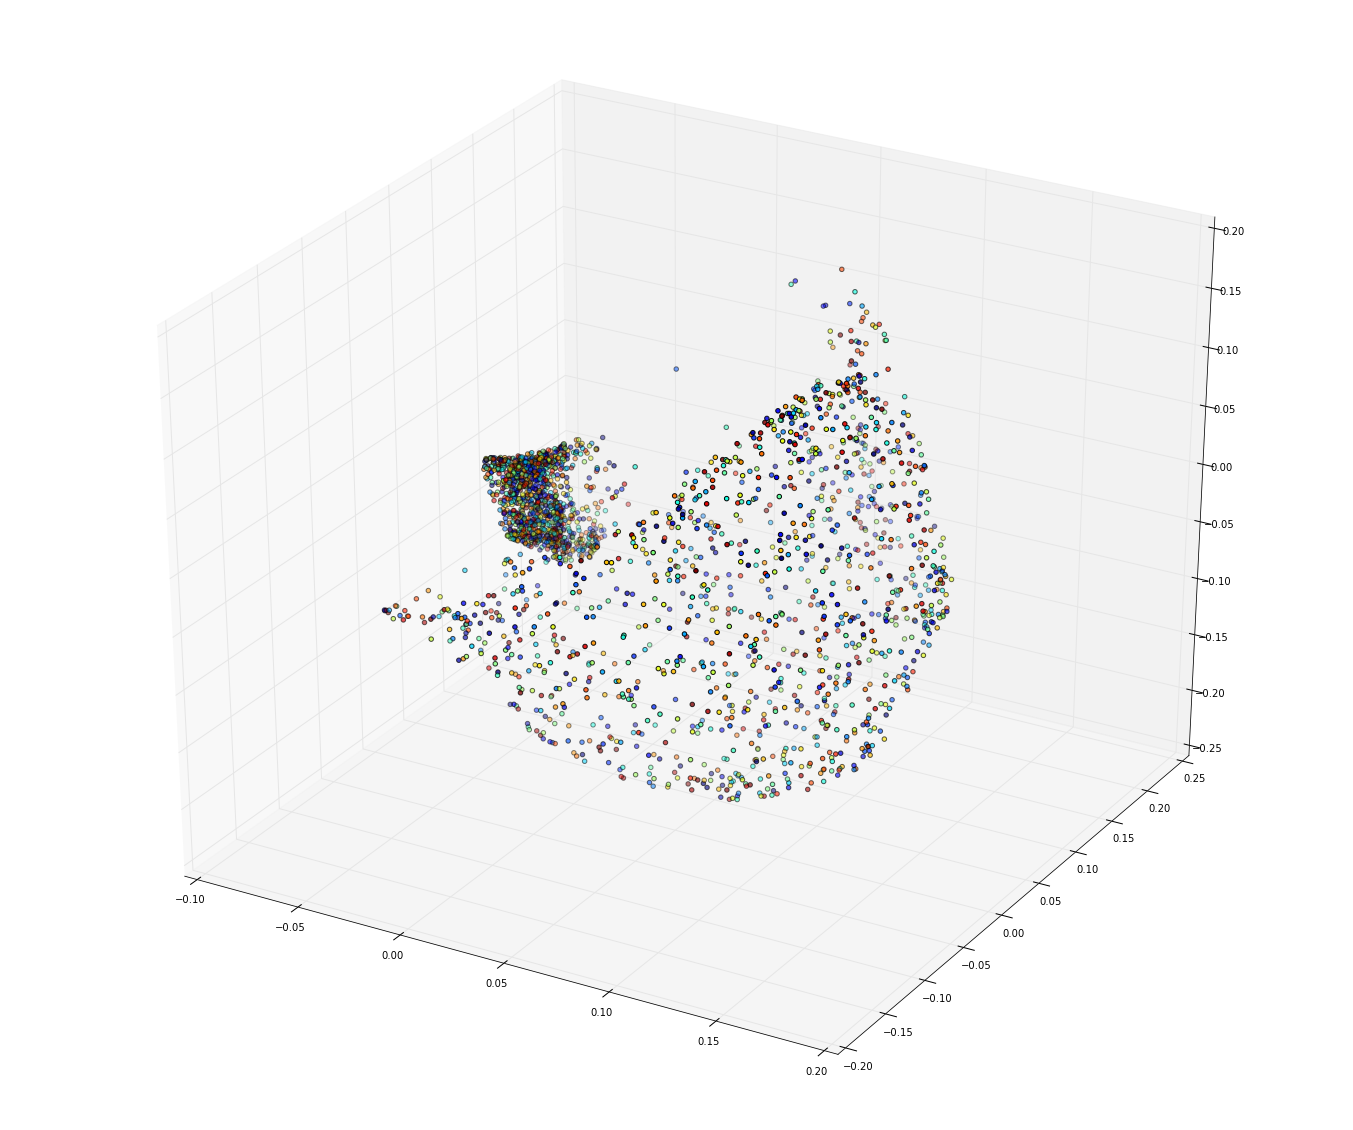

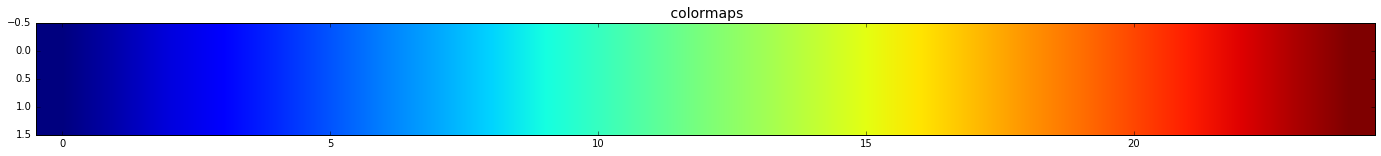

In [164]:
diffusion_params["gaussian_epsilon"] = 0.2 ## width of Gaussian kernel.
run_diffusion_maps_time_slices_plot_3d(sorting = "photon_num")

## I cannot discern much from the time-sliced diagrams above.

## Out of curiosity, what happens if we use the Euclidean norm over time?

using num_neighbors  


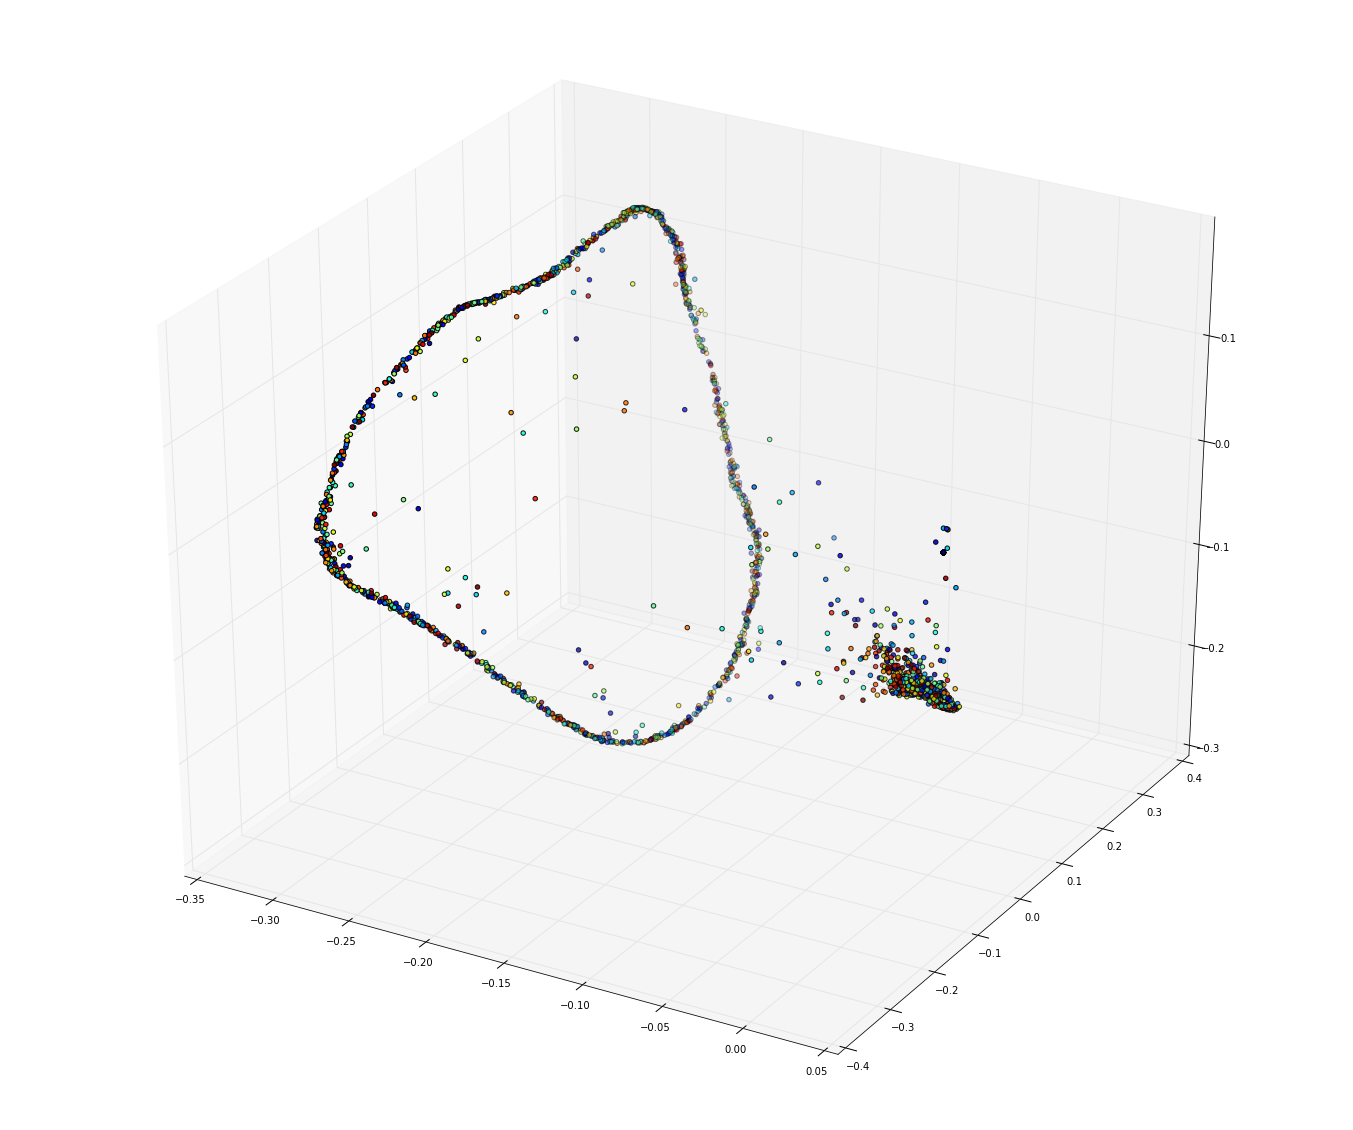

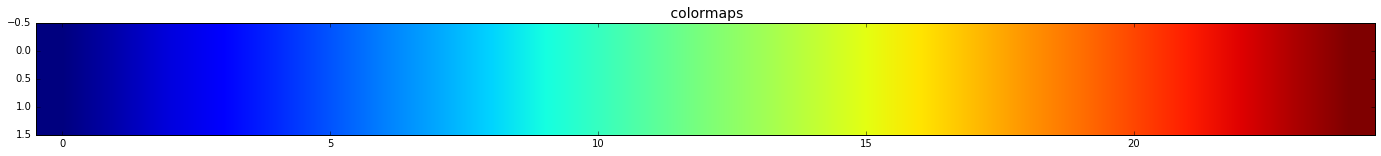

using num_neighbors  


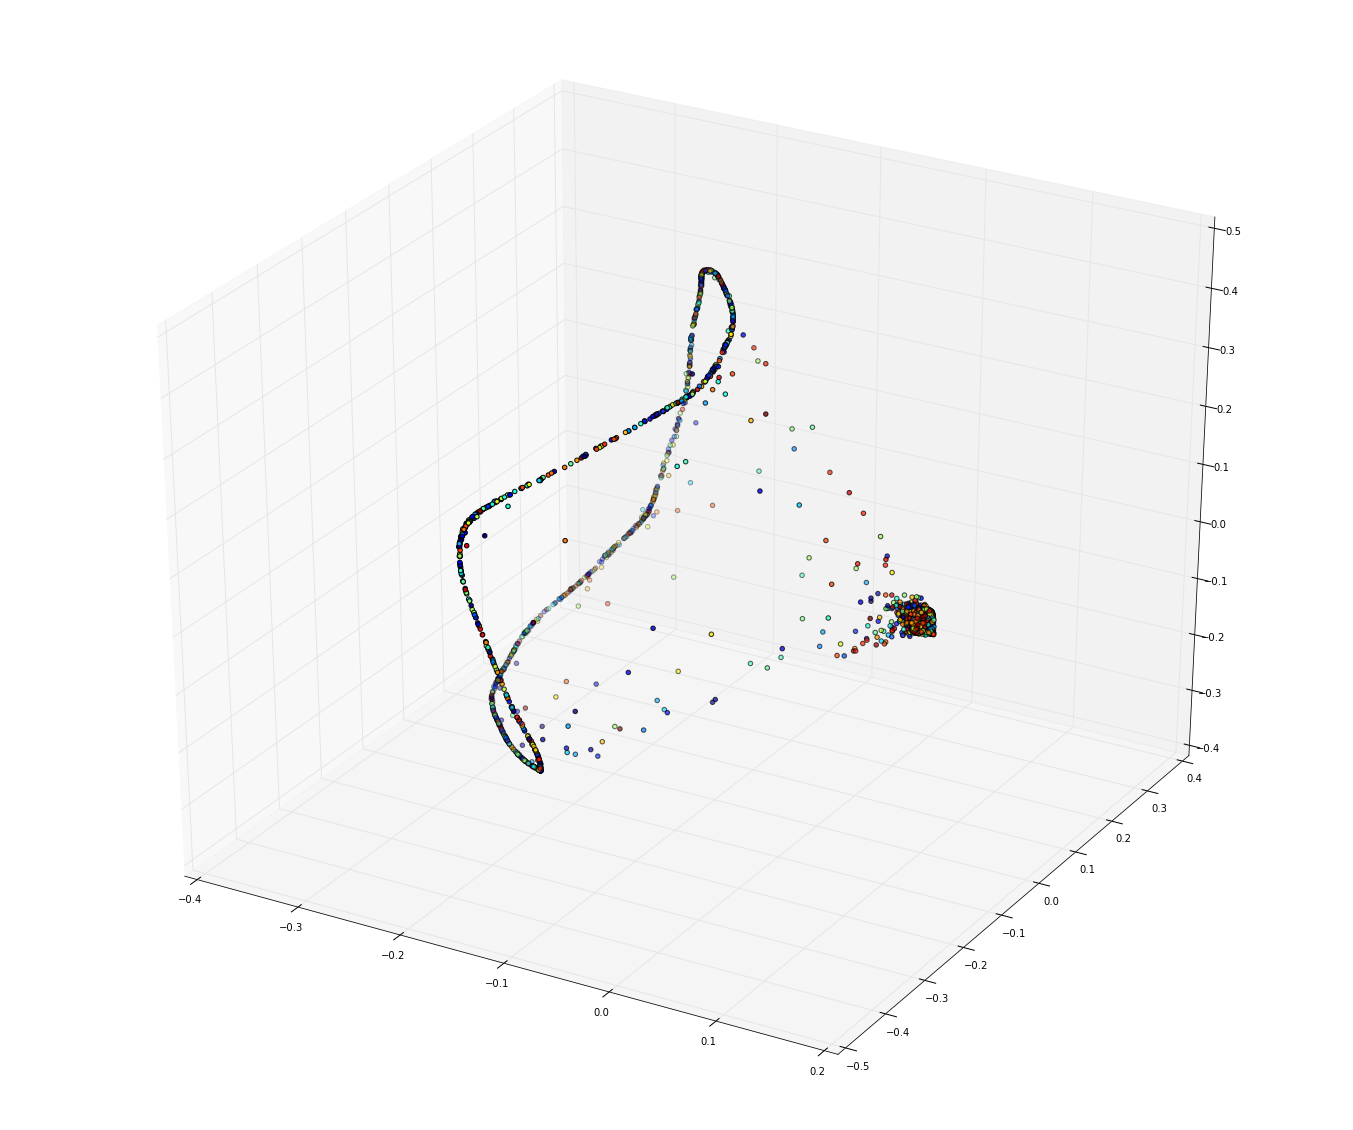

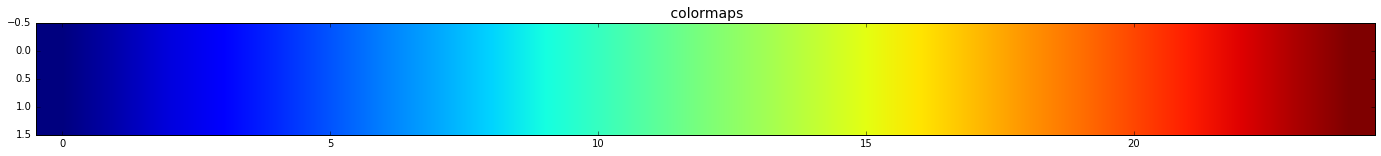

using num_neighbors  


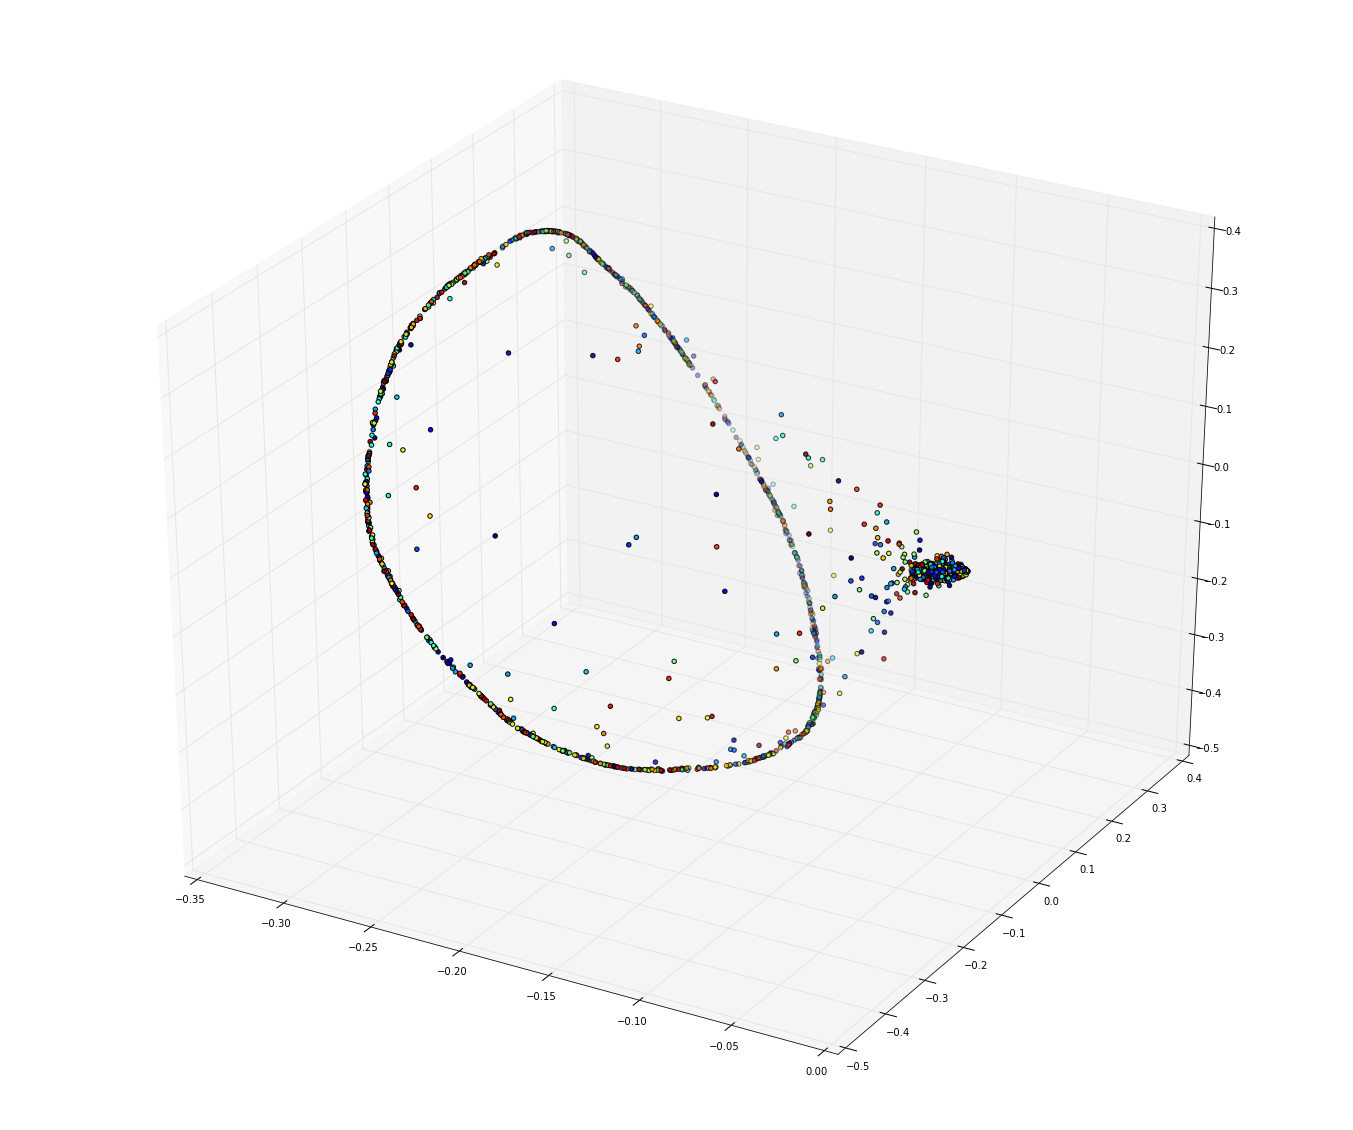

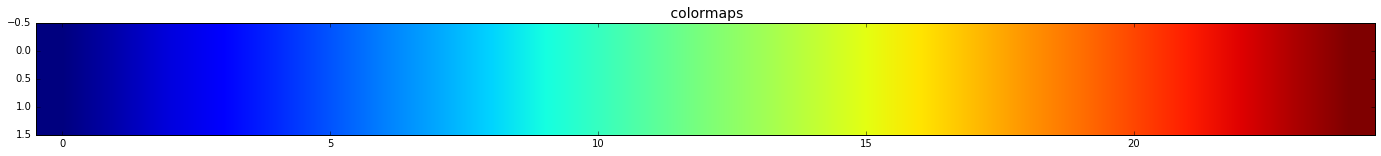

using num_neighbors  


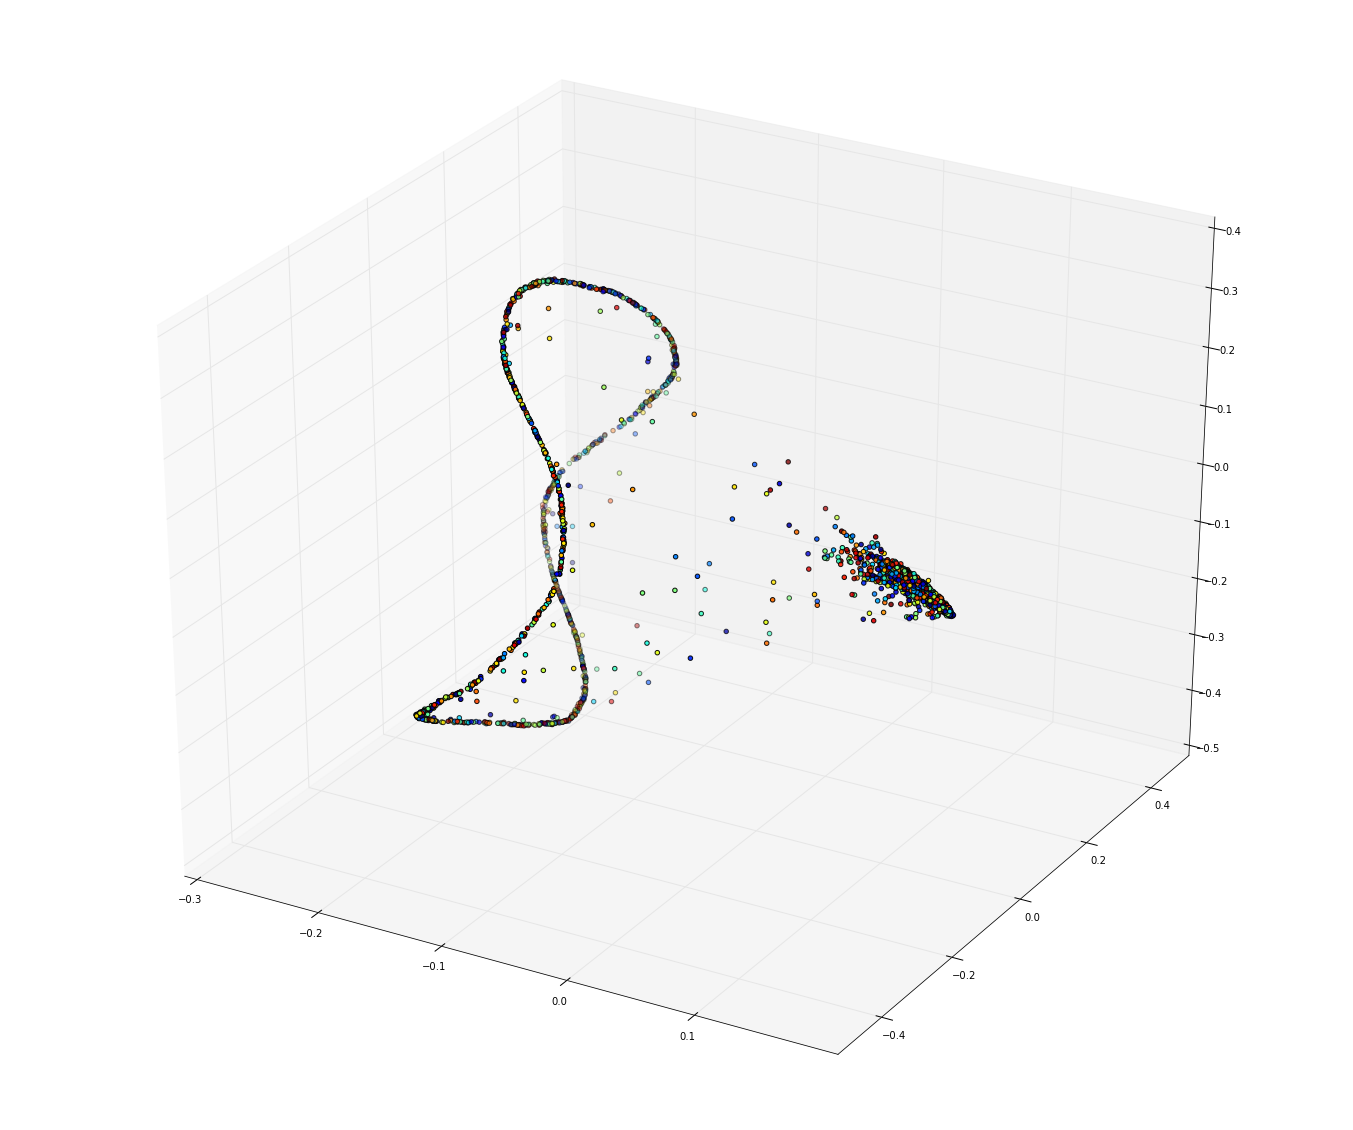

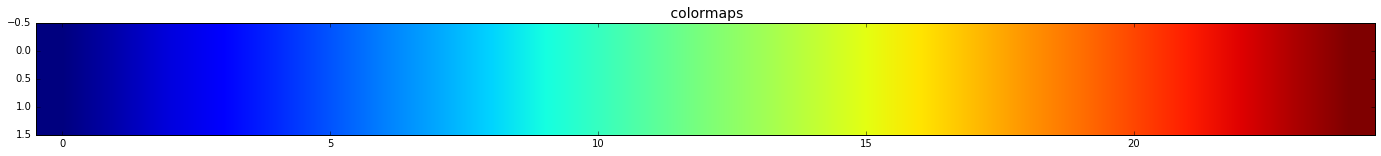

using num_neighbors  


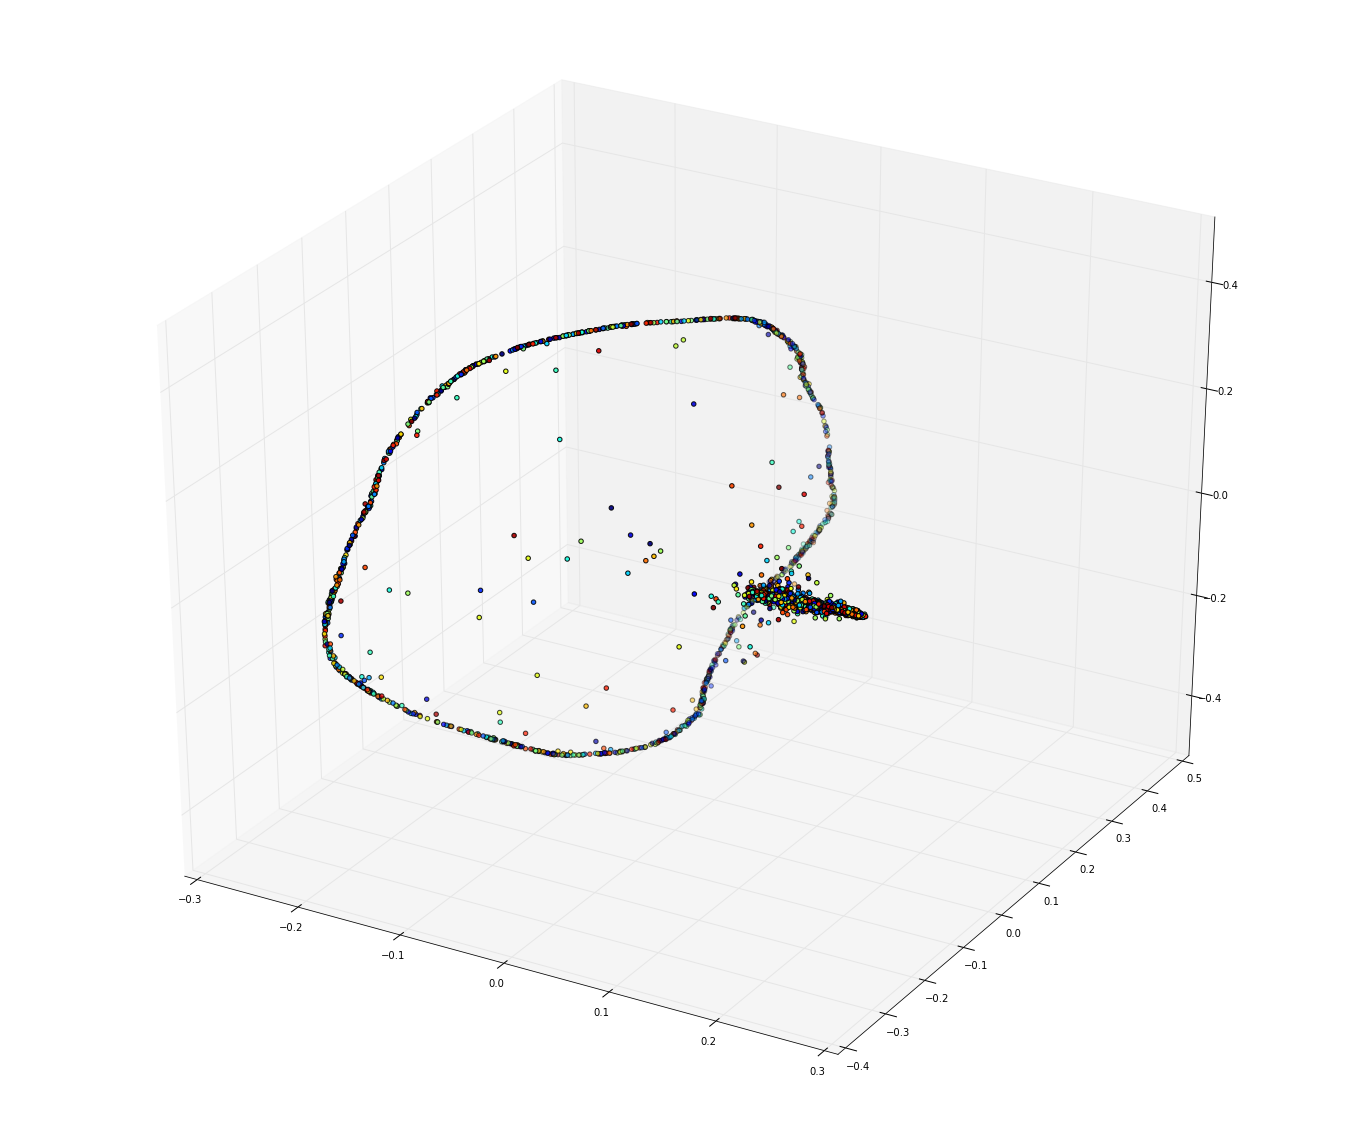

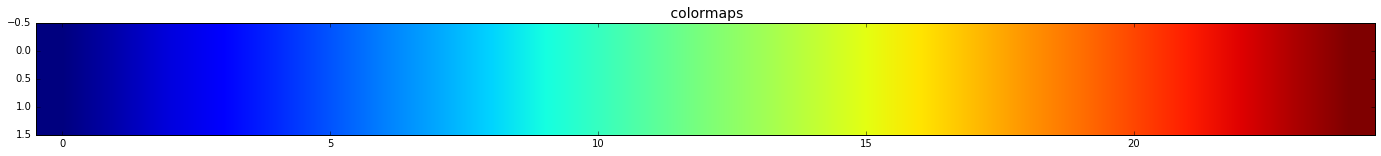

In [51]:
diffusion_params["gaussian_epsilon"] = 0.2 ## width of Gaussian kernel.
run_diffusion_maps_time_slices_plot_3d(metric="euclidean")

## 2D plots below with different values of `gaussian_epsilon`.

In [52]:
def run_diffusion_maps_time_slices_plot_2d():
    diffusion_params["eigen_dims"] = 3 ## number of lower dimensions to consider, i.e. number of eigenvectors to find.

    for t,traj1 in enumerate(traj_overtime):
        e_vals, e_vecs = run_diffusion_map(traj1.tolist(),
                                           diffusion_params,
                                           symmetric=True,
                                           metric = "FS_metric",
                                           neighbor_selection = "num_neighbors")

        data = e_vecs.T[1:]

        ## figure
        plt.scatter(*data) 
        plt.show()

using num_neighbors  


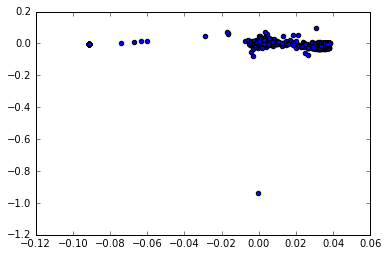

using num_neighbors  


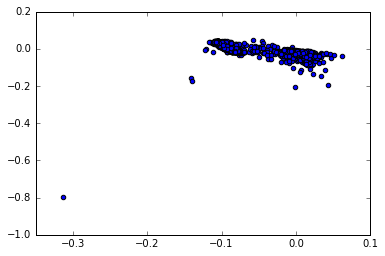

using num_neighbors  


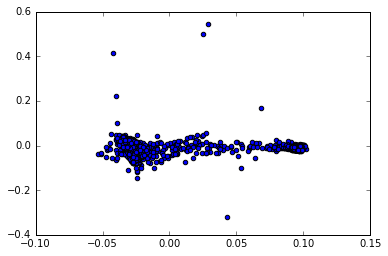

using num_neighbors  


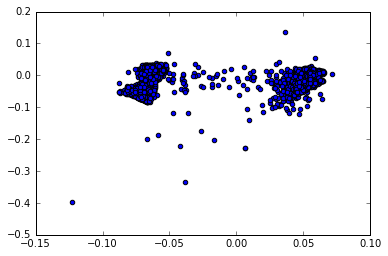

using num_neighbors  


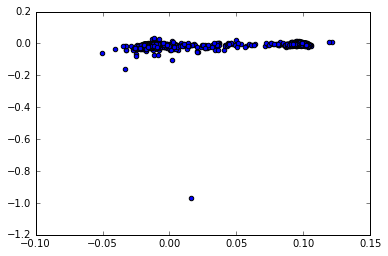

In [53]:
diffusion_params["gaussian_epsilon"] = 0.1 ## width of Gaussian kernel.
run_diffusion_maps_time_slices_plot_2d()

using num_neighbors  


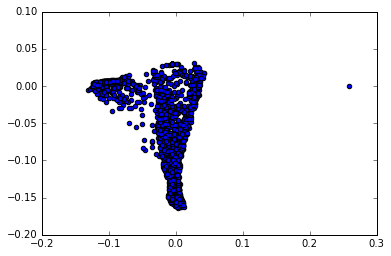

using num_neighbors  


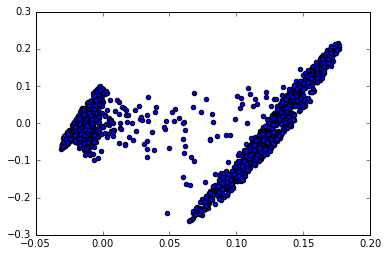

using num_neighbors  


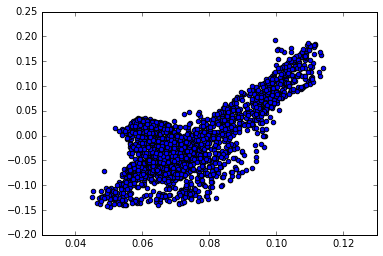

using num_neighbors  


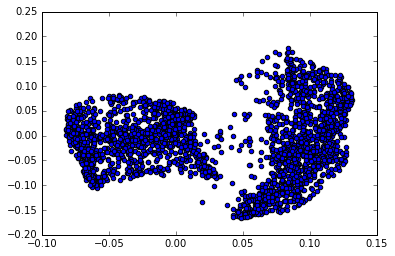

using num_neighbors  


In [54]:
diffusion_params["gaussian_epsilon"] = 0.2 ## width of Gaussian kernel.
run_diffusion_maps_time_slices_plot_2d()

## Comments